In [38]:

import math
import os.path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.ndimage import gaussian_filter1d

from src.classes.data.DataPreprocessor import DataPreprocessor
from src.classes.data.DataSplitter import DataSplitter
from src.classes.data.DatasetLoader import DatasetLoader
from src.classes.periodicity.ModelFactory import ModelFactory
from src.classes.utils.Logger import Logger
from src.classes.utils.PeriodicityDetector import PeriodicityDetector
from src.config import DATASET_ID, CLASSIFICATION, MODEL

os.chdir("/Users/matteorizzo/PycharmProjects/brewery-ml")

PATH_TO_MODEL = os.path.join("results", DATASET_ID, MODEL, f"{MODEL}_fold_0.pth")

logger = Logger()

In [39]:
x, y = DatasetLoader().load_dataset(DATASET_ID)

dataset_config = DatasetLoader().get_dataset_config(DATASET_ID)

cat_cols = dataset_config["cat_cols"]
numerical_columns = [col for col in x.columns if col not in cat_cols]
categorical_columns = [col for col in x.columns if col in cat_cols]

ordered_columns = numerical_columns + categorical_columns
x = x[ordered_columns]

feature_names = ordered_columns
for i, feature_name in enumerate(feature_names):
    print(i + 1, feature_name)

INFO: Dataset 'beer-fermentation' loaded successfully from disk.

1 ABD
2 Alcol % peso
3 Alcol % vol
4 Attenuazione Reale (RDF) %
5 Attenuazione vendita apparente %p
6 Cellule all'insemenzamento
7 Diacetile + precursori (ferm.)
8 Differenza apparente-limite
9 Durata di conservazione lievito in cella
10 Estratto apparente
11 Estratto apparente limite %Pp
12 Estratto reale 
13 Fermentation rate (13.5Â°-5.5Â°)
14 Grado primitivo %Pp
15 Hopped Wort
16 Hopped Wort (37Â°C)
17 NBB-A
18 NBB-B
19 Pentandione + precursori
20 pH
21 Rapporto ER/ABW
22 Temperatura Fermentazione
23 Temp. lievito all'insemenzamento
24 Brand
25 Chill-back Start Time
26 Durata raffreddamento
27 Occupancy in fermentation


In [40]:
x_num_cols = [col for col in numerical_columns if col != 'month']
idx_periodic, idx_non_periodic = [], []

logger.info(f"Analyzing periodicity for {len(x_num_cols)} numerical features.")
for column in x_num_cols:
    series = x[column].values
    if PeriodicityDetector().detect_periodicity_acf(series):
        logger.debug(f"Feature '{column}' detected as periodic.")
        idx_periodic.append(x.columns.get_loc(column))
    else:
        logger.debug(f"Feature '{column}' detected as non-periodic.")
        idx_non_periodic.append(x.columns.get_loc(column))

INFO: Analyzing periodicity for 23 numerical features.

/Users/matteorizzo/PycharmProjects/brewery-ml/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


DEBUG: Feature 'ABD' detected as non-periodic.

DEBUG: Feature 'Alcol % peso' detected as non-periodic.

DEBUG: Feature 'Alcol % vol' detected as non-periodic.

DEBUG: Feature 'Attenuazione Reale (RDF) %' detected as non-periodic.

DEBUG: Feature 'Attenuazione vendita apparente %p' detected as non-periodic.

DEBUG: Feature 'Cellule all'insemenzamento' detected as non-periodic.

DEBUG: Feature 'Diacetile + precursori (ferm.)' detected as non-periodic.

DEBUG: Feature 'Differenza apparente-limite' detected as non-periodic.

DEBUG: Feature 'Durata di conservazione lievito in cella' detected as non-periodic.

DEBUG: Feature 'Estratto apparente' detected as non-periodic.

DEBUG: Feature 'Estratto apparente limite %Pp' detected as non-periodic.

DEBUG: Feature 'Estratto reale ' detected as non-periodic.

DEBUG: Feature 'Fermentation rate (13.5Â°-5.5Â°)' detected as non-periodic.

DEBUG: Feature 'Grado primitivo %Pp' detected as non-periodic.

DEBUG: Feature 'Hopped Wort' detected as non-periodic.

DEBUG: Feature 'Hopped Wort (37Â°C)' detected as non-periodic.

DEBUG: Feature 'NBB-A' detected as non-periodic.

DEBUG: Feature 'NBB-B' detected as periodic.

DEBUG: Feature 'Pentandione + precursori' detected as non-periodic.

DEBUG: Feature 'pH' detected as non-periodic.

DEBUG: Feature 'Rapporto ER/ABW' detected as non-periodic.

DEBUG: Feature 'Temperatura Fermentazione' detected as non-periodic.

DEBUG: Feature 'Temp. lievito all'insemenzamento' detected as non-periodic.

In [41]:
idx_num = [x.columns.get_loc(col) for col in numerical_columns]
idx_cat = [x.columns.get_loc(col) for col in categorical_columns]

In [42]:
preprocessor = DataPreprocessor(x, y, cat_cols)
x_original_shape = x.shape
x = preprocessor.make_preprocessor().fit_transform(x)
if CLASSIFICATION:
    y = preprocessor.encode_target()

INFO: DataPreprocessor initialized with 23 numerical and 4 categorical columns.

INFO: Starting data preprocessing: Scaling numerical and encoding categorical features...

INFO: Data preprocessing complete.

In [43]:
# Initialize the DataSplitter
logger.info("Initializing the DataSplitter with input features and indices.")
data_splitter = DataSplitter(x, y, idx_num, idx_cat, idx_periodic, idx_non_periodic)

# Split the data and assign train/test sets
logger.info("Splitting the data into training and test sets.")
split_data = data_splitter.split()
input_sizes = split_data['input_sizes']
train_data, test_data = split_data["train"], split_data["val"]
logger.info("Data split completed. Train and test sets created.")

# Prepare train and test inputs
logger.info("Preparing periodic, non-periodic, and categorical data for training and test sets.")
x_num_p_train, x_num_np_train, x_cat_train = train_data["x_num_p"], train_data["x_num_np"], train_data["x_cat"]
x_num_p_test, x_num_np_test, x_cat_test = test_data["x_num_p"], test_data["x_num_np"], test_data["x_cat"]

# Combine numerical and categorical data
x_num_train = torch.cat([x_num_p_train, x_num_np_train], dim=-1)
x_train = torch.cat([x_num_train, x_cat_train], dim=-1)
logger.debug(f"Training input shape: {x_train.shape}")

x_num_test = torch.cat([x_num_p_test, x_num_np_test], dim=-1)
x_test = torch.cat([x_num_test, x_cat_test], dim=-1)
logger.debug(f"Test input shape: {x_test.shape}")

# Prepare train and test labels
y_train, y_test = train_data["y"], test_data["y"]
logger.debug(f"Training label shape: {y_train.shape}")
logger.debug(f"Test label shape: {y_test.shape}")

# Determine output size based on classification or regression
output_size = y.nunique() if CLASSIFICATION else 1
logger.info(f"Output size determined: {output_size} (classification={CLASSIFICATION})")

# Initialize model using ModelFactory
logger.info("Initializing the model with ModelFactory.")
model_factory = ModelFactory(
    num_periodic_input_size=input_sizes['num_periodic_input_size'],
    num_non_periodic_input_size=input_sizes['num_non_periodic_input_size'],
    cat_input_size=input_sizes['cat_input_size'],
    output_size=output_size,
    dataset_config=dataset_config
)
model = model_factory.get_model(MODEL).network
logger.info("Model initialized successfully.")
print(model)

# Load model weights with `strict=False` to ignore mismatched keys
try:
    state_dict = torch.load(PATH_TO_MODEL)
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

    # Log any missing or unexpected keys
    if missing_keys:
        logger.warning(f"Missing keys in the loaded state_dict: {missing_keys}")
    if unexpected_keys:
        logger.warning(f"Unexpected keys in the loaded state_dict: {unexpected_keys}")

    logger.info(f"Model weights loaded successfully from {PATH_TO_MODEL}.")

except FileNotFoundError:
    logger.error(f"Model file not found at {PATH_TO_MODEL}. Please check the path.")
    raise
except RuntimeError as e:
    logger.error(f"Runtime error in loading model state_dict: {e}")
    raise

# Retrieve the encoder layer for further processing
encoder = model.processing_layer.layers[0]
logger.info("Encoder layer retrieved for further processing.")


INFO: Initializing the DataSplitter with input features and indices.

INFO: Splitting the data into training and test sets.

INFO: Data split completed. Train and test sets created.

INFO: Preparing periodic, non-periodic, and categorical data for training and test sets.

DEBUG: Training input shape: torch.Size([4213, 27])

DEBUG: Test input shape: torch.Size([469, 27])

DEBUG: Training label shape: torch.Size([4213, 1])

DEBUG: Test label shape: torch.Size([469, 1])

INFO: Output size determined: 1 (classification=False)

INFO: Initializing the model with ModelFactory.

INFO: Model initialized successfully.

FourierNet(
  (processing_layer): FourierBlock(
    (layers): ModuleList(
      (0): FourierEncoder(
        (kernel): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
      )
    )
    (compress_layers): ModuleList()
    (norm_layers): ModuleList()
    (dropout_layers): ModuleList()
  )
  (mlp): MLP(
    (network): Sequential(
      (0): Linear(in_features=4600, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)


INFO: Model weights loaded successfully from results/beer-fermentation/fnet/fnet_fold_0.pth.

INFO: Encoder layer retrieved for further processing.

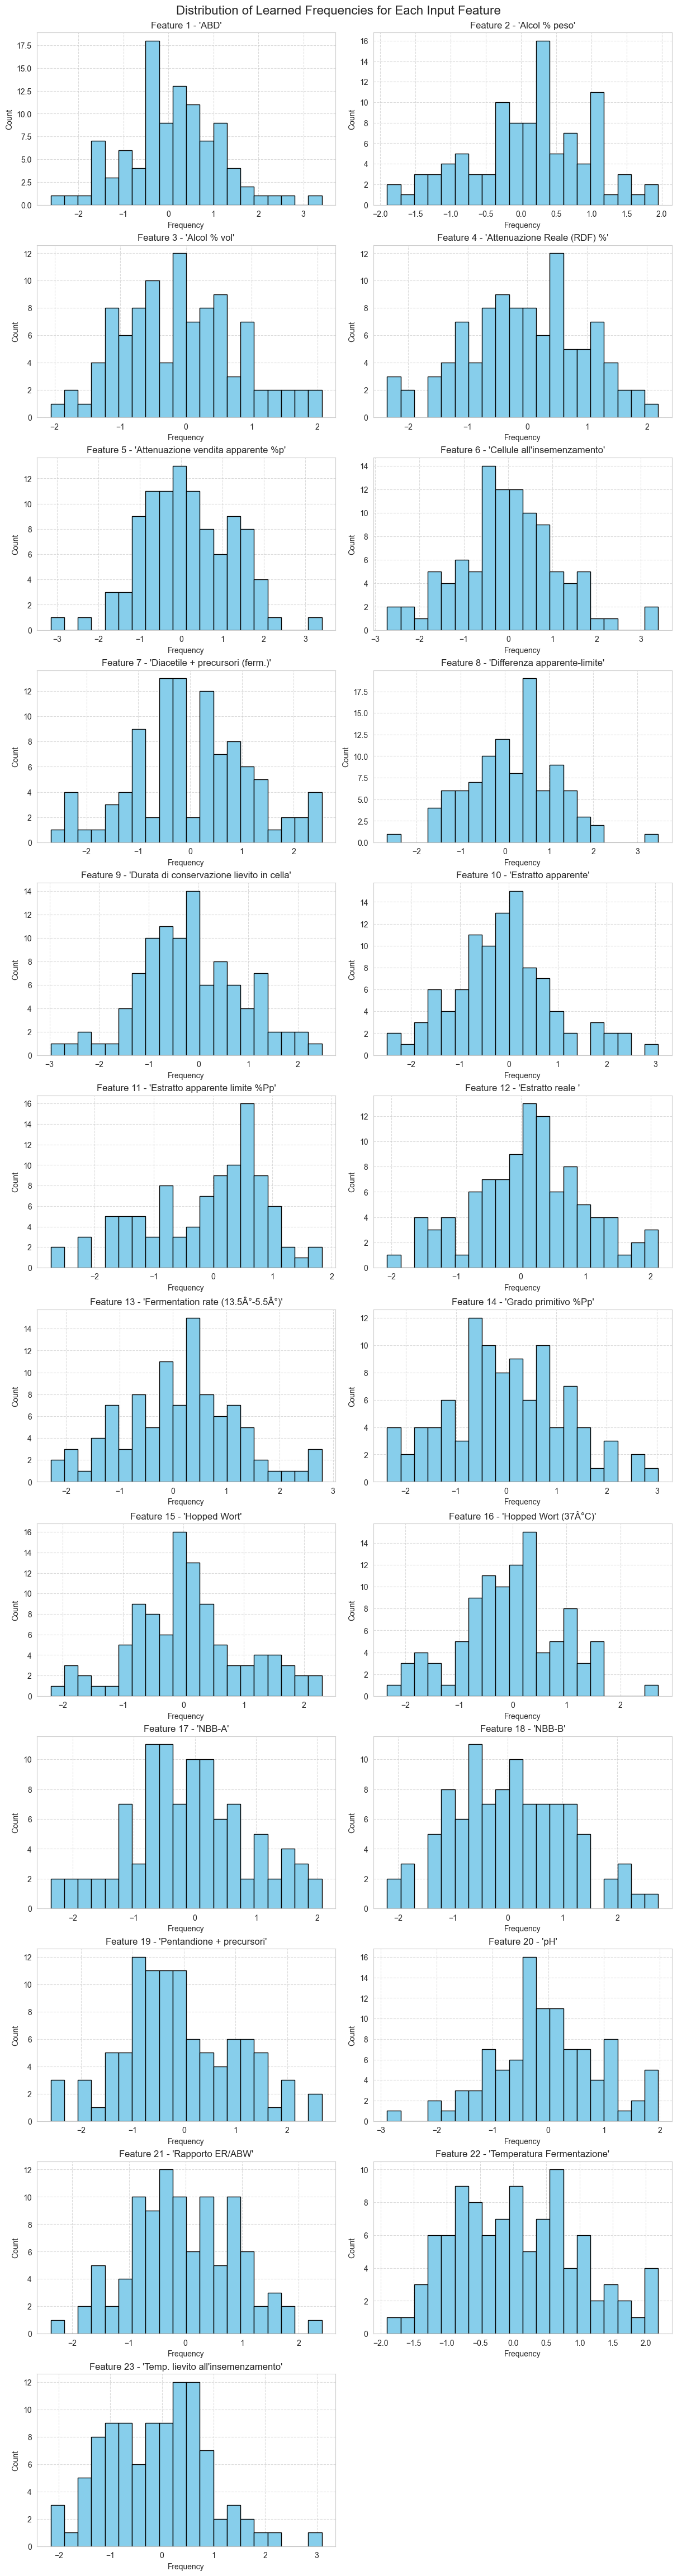

In [44]:
# Assuming `encoder` is your FourierEncoder instance
B_values = encoder.B.detach().cpu().numpy()  # Detach and move to CPU for plotting

# Set up subplots to show each input feature's frequency distribution separately
num_features = B_values.shape[0]
fig, axes = plt.subplots(nrows=num_features // 2 + num_features % 2, ncols=2, figsize=(12, 2 * num_features),
                         constrained_layout=True)

axes = axes.flatten()  # Flatten to easily iterate
for i, ax in enumerate(axes[:num_features]):
    frequencies = B_values[i]
    ax.hist(frequencies, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f"Feature {i + 1} - '{feature_names[i]}'")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.7)

# Remove empty subplots if the number of features is odd
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Learned Frequencies for Each Input Feature", fontsize=16)
plt.show()


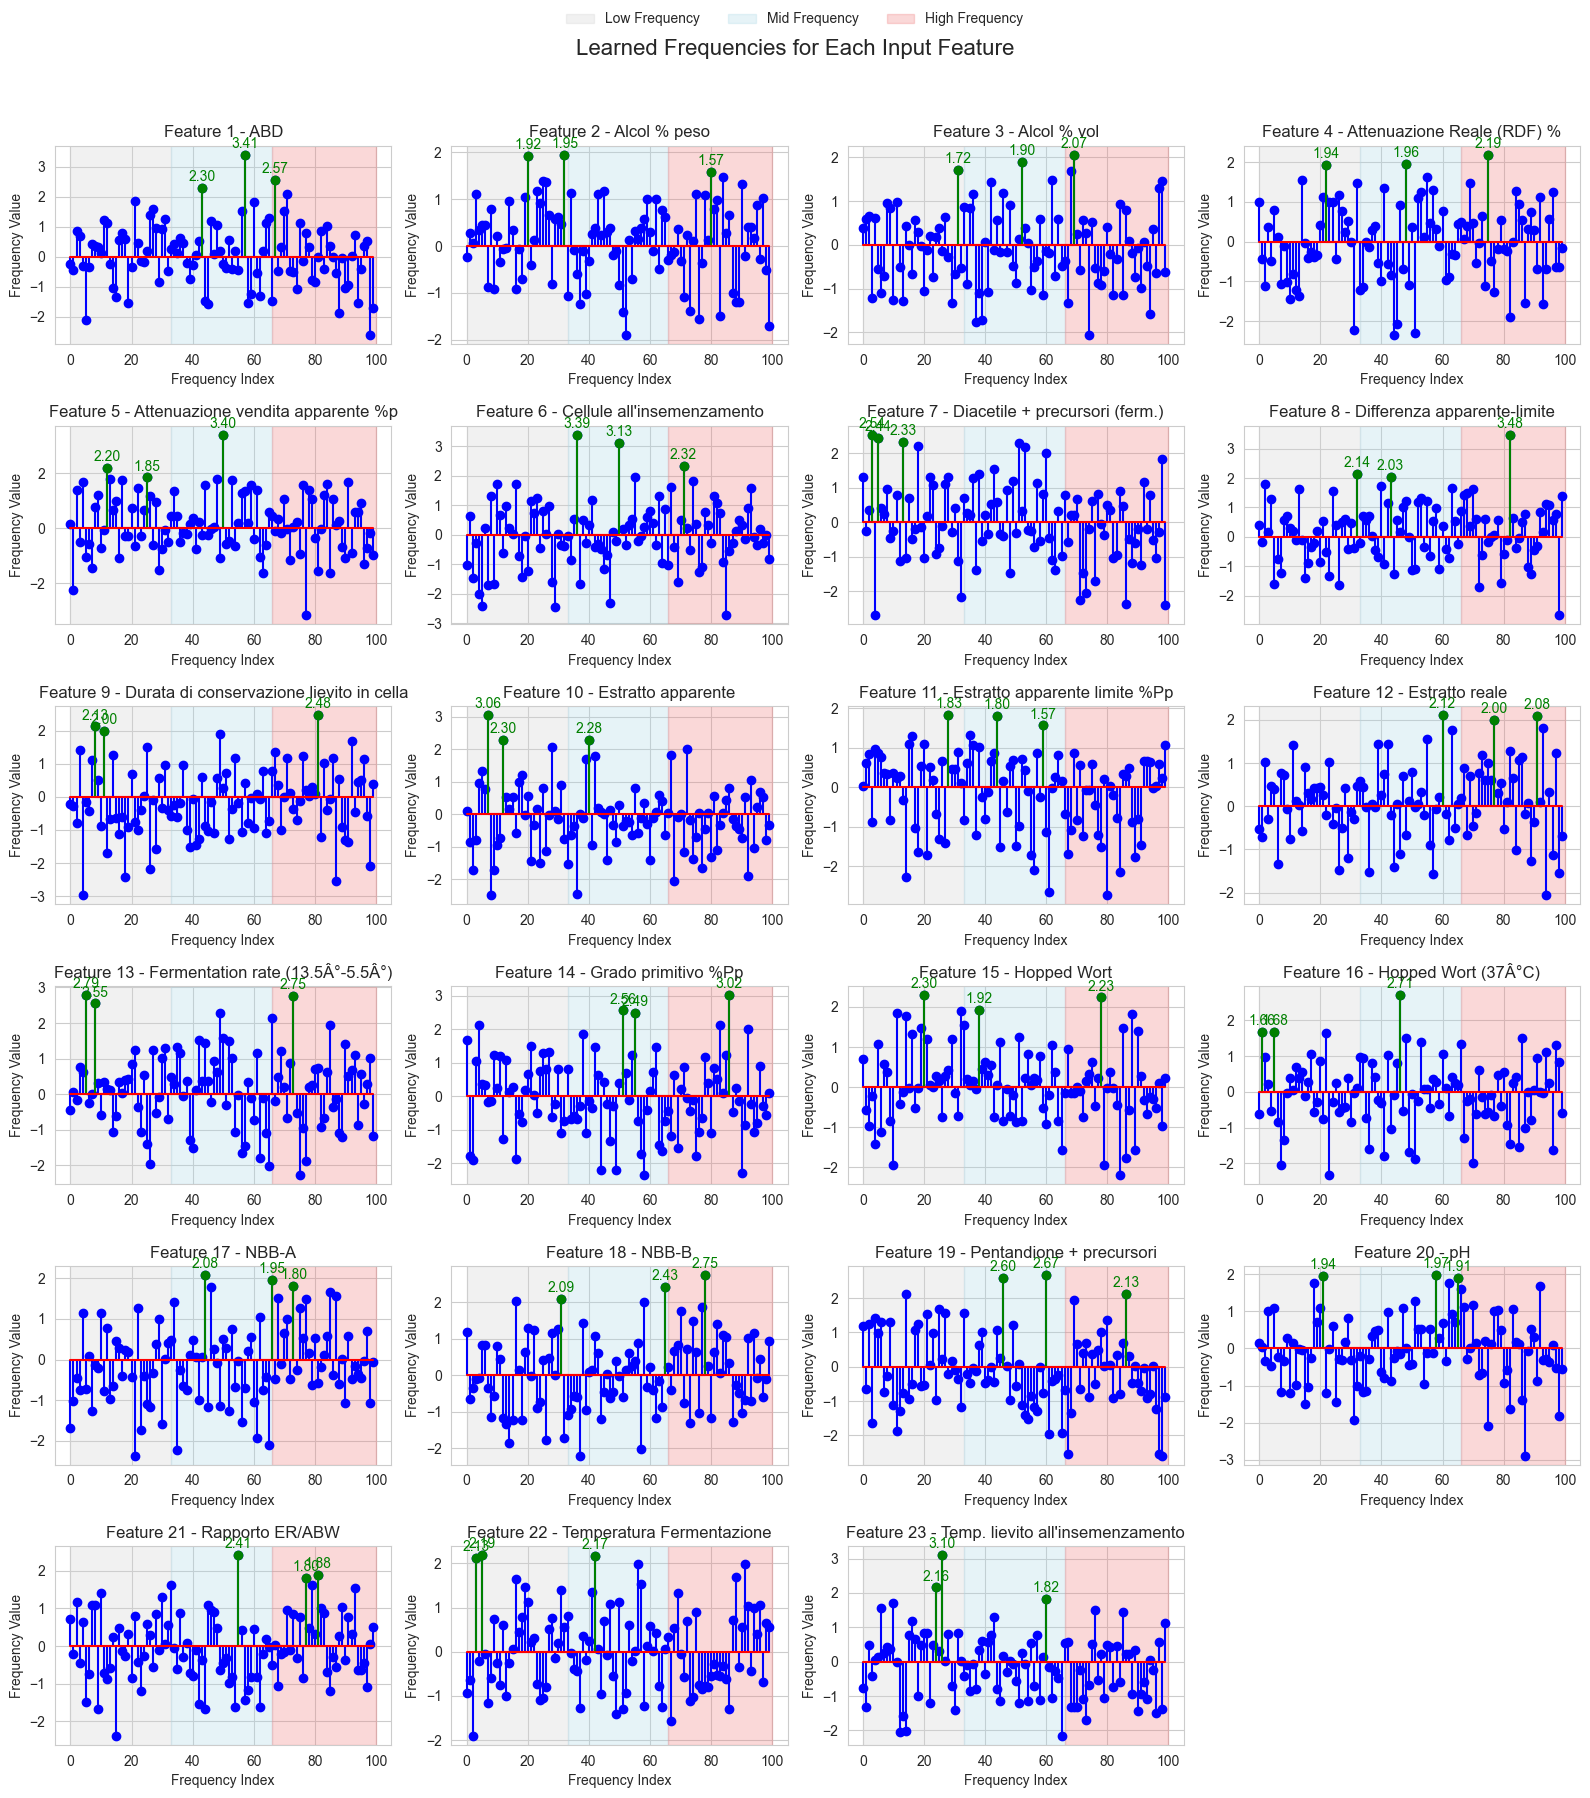

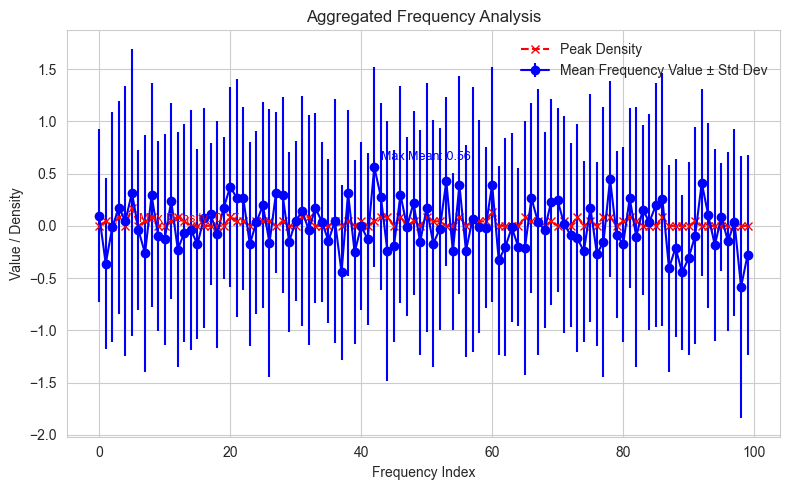

In [45]:
# Assuming `encoder.input_size` is the number of input features
# and `B_values` contains the learned frequencies

num_features = encoder.input_size
cols = 4  # Number of columns for subplots
rows = math.ceil(num_features / cols)  # Calculate rows based on number of features

# Create figure for individual feature plots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each feature's learned frequencies
for i in range(num_features):
    frequencies = B_values[i, :]
    ax = axes[i]

    # Highlight the top 3 peaks
    peak_indices = np.argsort(frequencies)[-3:]  # Indices of the top 3 peaks
    ax.stem(frequencies, linefmt='b-', markerfmt='bo', basefmt='r-')
    ax.stem(peak_indices, frequencies[peak_indices], linefmt='g-', markerfmt='go', basefmt='r-')

    # Annotate the peaks
    for idx in peak_indices:
        ax.annotate(f"{frequencies[idx]:.2f}",
                    (idx, frequencies[idx]),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha='center', color="green")

    # Shade specific frequency ranges
    low_range = ax.axvspan(0, len(frequencies) * 0.33, color='lightgray', alpha=0.3, label="Low Frequency")
    mid_range = ax.axvspan(len(frequencies) * 0.33, len(frequencies) * 0.66, color='lightblue', alpha=0.3,
                           label="Mid Frequency")
    high_range = ax.axvspan(len(frequencies) * 0.66, len(frequencies), color='lightcoral', alpha=0.3,
                            label="High Frequency")

    ax.set_title(f"Feature {i + 1} - {feature_names[i]}")
    ax.set_xlabel("Frequency Index")
    ax.set_ylabel("Frequency Value")
    ax.grid(True)

# Remove any empty subplots if the number of features isn't a perfect multiple of `cols`
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Add legend for frequency ranges on one of the individual plots
handles = [low_range, mid_range, high_range]
labels = ["Low Frequency", "Mid Frequency", "High Frequency"]
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, frameon=False)

fig.suptitle("Learned Frequencies for Each Input Feature", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the supertitle
plt.show()

# Create separate figure for the aggregated plot
fig_agg, aggregated_ax = plt.subplots(figsize=(8, 5))

# Calculate the mean and standard deviation of frequency values across all features
mean_frequencies = np.mean(B_values, axis=0)
std_frequencies = np.std(B_values, axis=0)

# Plot the mean frequency values with error bars
aggregated_ax.errorbar(
    range(len(mean_frequencies)),
    mean_frequencies,
    yerr=std_frequencies,
    color="blue",
    label="Mean Frequency Value ± Std Dev",
    fmt='-o'
)

# Calculate and plot density of peaks
all_peak_indices = np.argsort(B_values, axis=1)[:, -3:]  # Top 3 peaks for each feature
peak_counts = np.zeros(B_values.shape[1])  # Initialize counts for each frequency index
for feature_peaks in all_peak_indices:
    for idx in feature_peaks:
        peak_counts[idx] += 1  # Count each peak

# Normalize and plot peak density
peak_density = peak_counts / num_features
aggregated_ax.plot(peak_density, color="red", linestyle="--", marker='x', label="Peak Density")

# Highlight max points in mean frequencies and peak density
max_mean_idx = np.argmax(mean_frequencies)
max_density_idx = np.argmax(peak_density)
aggregated_ax.annotate(f"Max Mean: {mean_frequencies[max_mean_idx]:.2f}",
                       (max_mean_idx, mean_frequencies[max_mean_idx]),
                       xytext=(5, 5), textcoords="offset points",
                       color="blue", fontsize=9)
aggregated_ax.annotate(f"Max Density: {peak_density[max_density_idx]:.2f}",
                       (max_density_idx, peak_density[max_density_idx]),
                       xytext=(5, -10), textcoords="offset points",
                       color="red", fontsize=9)

# Aggregated plot labels and legend
aggregated_ax.set_title("Aggregated Frequency Analysis")
aggregated_ax.set_xlabel("Frequency Index")
aggregated_ax.set_ylabel("Value / Density")
aggregated_ax.grid(True)
aggregated_ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


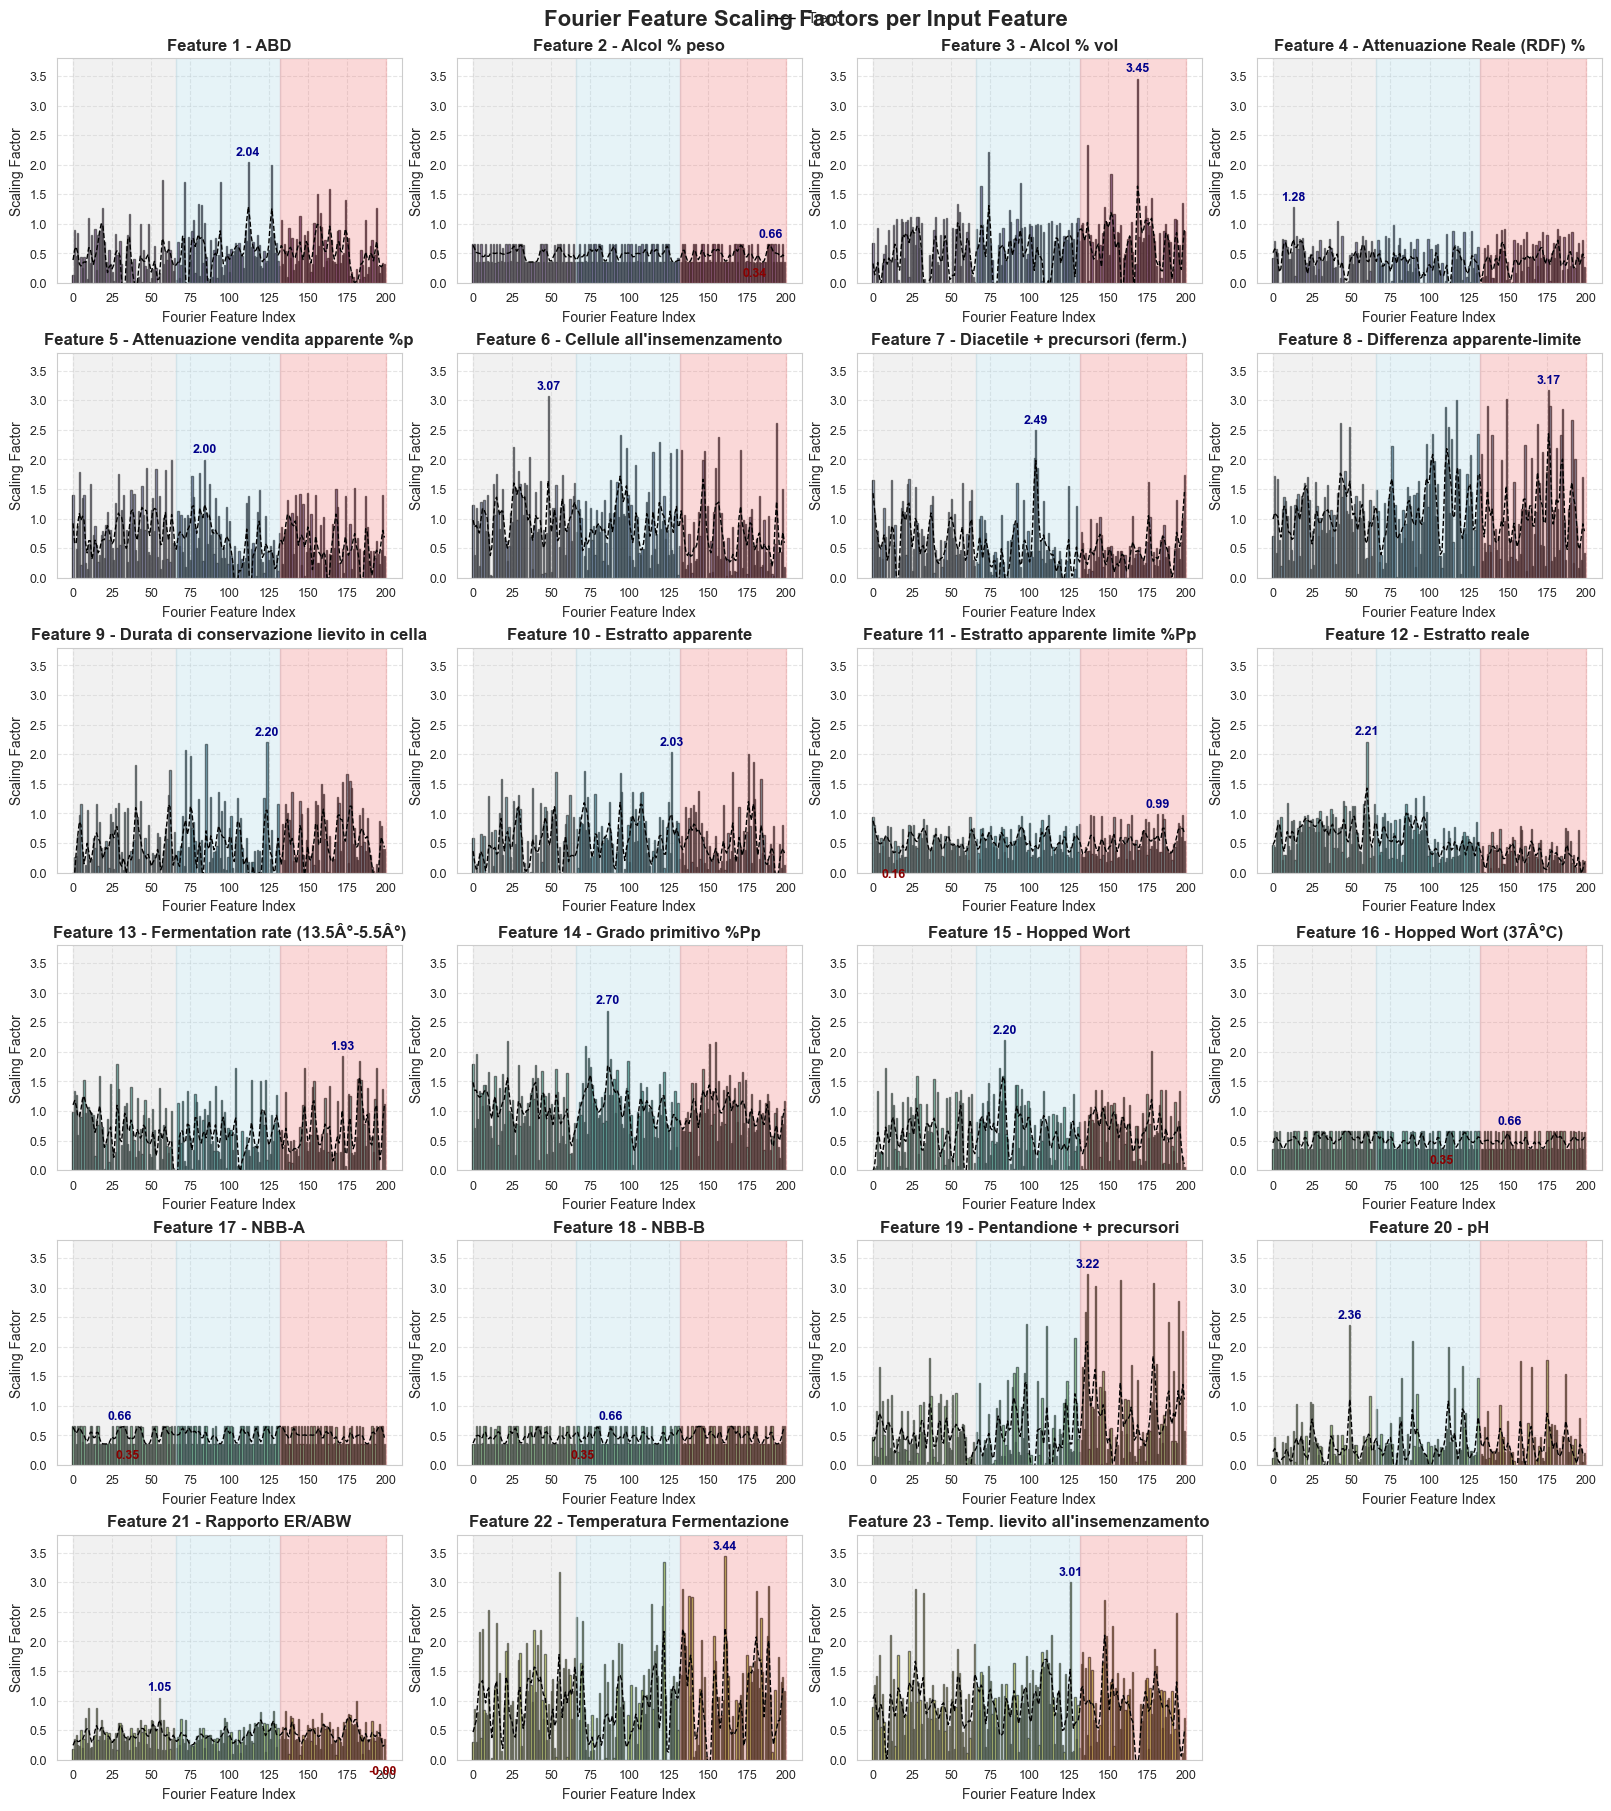

In [46]:
# Detach feature scaling values, move to CPU, and convert to numpy
feature_scaling_values = encoder.feature_scaling.detach().cpu().numpy()

# Set seaborn style for improved aesthetics
sns.set_style("whitegrid")

# Determine the number of Fourier feature groups (assuming shape [input_size, num_features_per_input * 2])
num_features, num_fourier_features = feature_scaling_values.shape

# Define grid layout for subplots
cols = 4  # Number of columns for subplots
rows = math.ceil(num_features / cols)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), constrained_layout=True)
axes = axes.flatten()  # Flatten to iterate easily

# Set consistent y-axis limit based on max scaling factor across all features
max_scaling_factor = feature_scaling_values.max() * 1.1

# Define a color palette for variety in feature plots
palette = sns.color_palette("viridis", num_features)

# Plot each Fourier feature scaling factor in a separate subplot
for i in range(num_features):
    ax = axes[i]
    color = palette[i]

    # Plot scaling factors as bars
    ax.bar(range(num_fourier_features), feature_scaling_values[i], color=color, edgecolor="black", alpha=0.7)

    # Highlight peak and trough (max and min values)
    max_idx = feature_scaling_values[i].argmax()
    min_idx = feature_scaling_values[i].argmin()
    max_value = feature_scaling_values[i][max_idx]
    min_value = feature_scaling_values[i][min_idx]
    ax.annotate(f"{max_value:.2f}", (max_idx, max_value), textcoords="offset points", xytext=(0, 5),
                ha='center', color="darkblue", fontsize=9, fontweight='bold')
    ax.annotate(f"{min_value:.2f}", (min_idx, min_value), textcoords="offset points", xytext=(0, -10),
                ha='center', color="darkred", fontsize=9, fontweight='bold')

    # Add a trend line with Gaussian smoothing
    smoothed_values = gaussian_filter1d(feature_scaling_values[i], sigma=1)
    ax.plot(range(num_fourier_features), smoothed_values, color="black", linestyle="--", linewidth=1, label="Trend")

    # Shade specific Fourier index ranges (low, mid, high frequency)
    ax.axvspan(0, num_fourier_features * 0.33, color='lightgray', alpha=0.3, label="Low Freq Range" if i == 0 else "")
    ax.axvspan(num_fourier_features * 0.33, num_fourier_features * 0.66, color='lightblue', alpha=0.3,
               label="Mid Freq Range" if i == 0 else "")
    ax.axvspan(num_fourier_features * 0.66, num_fourier_features, color='lightcoral', alpha=0.3,
               label="High Freq Range" if i == 0 else "")

    # Styling for each subplot
    ax.set_ylim(0, max_scaling_factor)  # Consistent y-axis limits
    ax.set_title(f"Feature {i + 1} - {feature_names[i]}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Fourier Feature Index", fontsize=10)
    ax.set_ylabel("Scaling Factor", fontsize=10)
    ax.grid(visible=True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='both', labelsize=9)
    ax.minorticks_on()

# Remove any empty subplots if the number of features is not a perfect multiple of `cols`
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

# Set the overall title with adjusted layout
fig.suptitle("Fourier Feature Scaling Factors per Input Feature", fontsize=16, fontweight='bold')

# Add a legend only once, for the shaded areas and trend line
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=10, frameon=False)

plt.show()


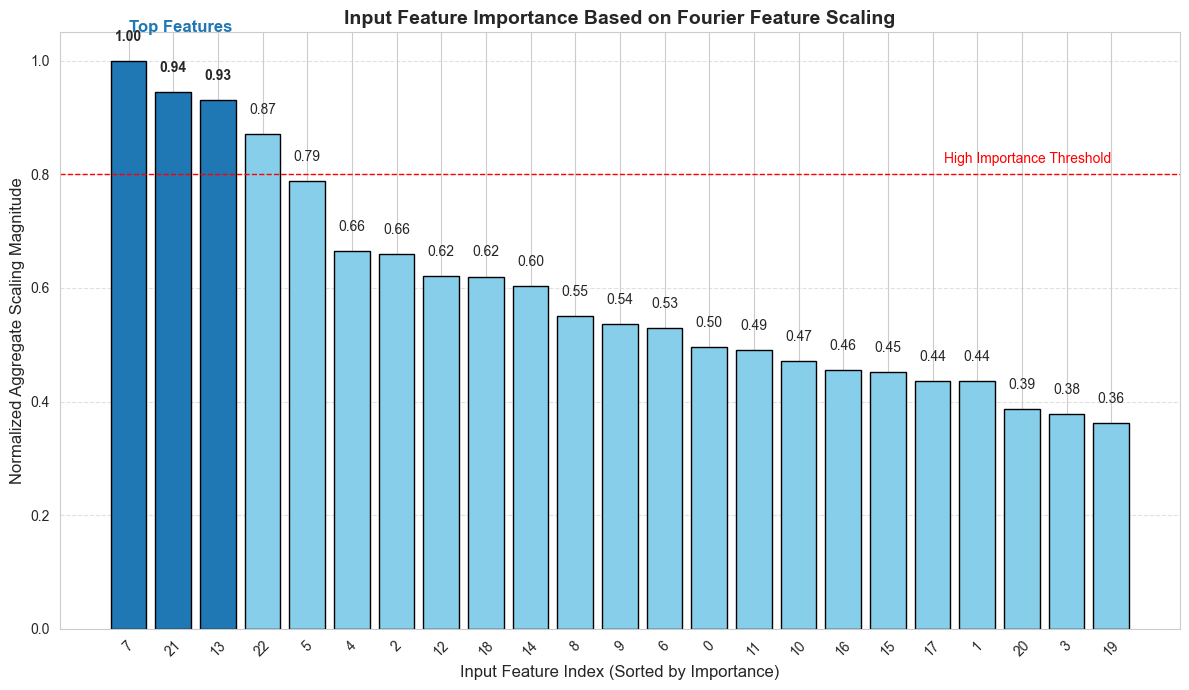

In [47]:
# Calculate feature scaling magnitudes
feature_scaling_magnitudes = np.abs(feature_scaling_values)
input_feature_importance = feature_scaling_magnitudes.reshape(encoder.input_size, -1).sum(axis=1)

# Normalize the importance values for easier interpretation
input_feature_importance /= input_feature_importance.max()  # Scale between 0 and 1

# Sort features by importance
sorted_indices = np.argsort(input_feature_importance)[::-1]  # Sort in descending order
sorted_importance = input_feature_importance[sorted_indices]

# Define colors: gradient for most to least important and a distinct color for top features
colors = ["#1f77b4" if i < 3 else "#87ceeb" for i in range(len(sorted_importance))]  # Dark blue for top 3

# Plotting
plt.figure(figsize=(12, 7))
bars = plt.bar(range(encoder.input_size), sorted_importance, color=colors, edgecolor="black")
plt.xticks(range(encoder.input_size), sorted_indices, rotation=45, fontsize=10)  # Show sorted feature indices

# Annotate each bar with its importance value and bold font for top features
for i, (bar, value) in enumerate(zip(bars, sorted_importance)):
    fontweight = "bold" if i < 3 else "regular"  # Highlight top 3 in bold
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f"{value:.2f}",
             ha="center", va="bottom", fontsize=10, fontweight=fontweight)

# Add a threshold line at 0.8 to indicate high importance features
threshold = 0.8
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=1)
plt.text(encoder.input_size - 1, threshold + 0.02, "High Importance Threshold", color="red", ha="right", fontsize=10)

# Labels and title with improved styling
plt.title("Input Feature Importance Based on Fourier Feature Scaling", fontsize=14, fontweight="bold")
plt.xlabel("Input Feature Index (Sorted by Importance)", fontsize=12)
plt.ylabel("Normalized Aggregate Scaling Magnitude", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Highlight top features with a title annotation
plt.text(0, 1.05, "Top Features", color="#1f77b4", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


In [48]:
def generate_counterfactuals_regression(
        sample_data: torch.Tensor,
        target_output: torch.Tensor,
        output_change_threshold: float,
        modification_percent: float
):
    """
    Generate counterfactual explanations for a regression model using Fourier feature importance.
    """
    logger.info("Starting counterfactual generation for a sample.")

    # Clone the sample data and add batch dimension
    sample_data = sample_data.clone().detach().unsqueeze(0)
    counterfactual_data = sample_data.clone()

    # Ensure target_output is a scalar
    original_target = target_output.item()

    # Get initial model output
    model.eval()
    with torch.no_grad():
        original_output = model(sample_data).item()
    
    logger.info(f"Original model output: {original_output:.4f}")
    
    # Identify important features
    important_features = np.where(input_feature_importance > 0.75)[0]
    feature_changes = []

    # Apply modification to important features and track changes
    for idx in important_features:
        original_feature_value = counterfactual_data[:, idx].item()
        counterfactual_data[:, idx] *= (1 + modification_percent)
        counterfactual_feature_value = counterfactual_data[:, idx].item()
        change_percentage = ((counterfactual_feature_value - original_feature_value) / original_feature_value) * 100
        feature_changes.append(change_percentage)
        
        logger.info(f"Feature {idx} - Original: {original_feature_value:.4f}, Counterfactual: {counterfactual_feature_value:.4f} (Change: {change_percentage:.2f}%)")

    # Get the model's prediction with modified data
    with torch.no_grad():
        modified_output = model(counterfactual_data).item()

    logger.info(f"Original output: {original_output:.4f}, Counterfactual output: {modified_output:.4f}")

    output_change = abs((modified_output - original_output) / original_output)
    target_change = abs((modified_output - original_target) / original_target)
    logger.info(f"Change in output: {output_change * 100:.2f}%, change w.r.t. target: {target_change * 100:.2f}%")

    # Check if the output change surpasses the specified threshold
    if output_change >= output_change_threshold:
        logger.info(f"Counterfactual achieved with output change of {target_change * 100:.2f}%.")
        return counterfactual_data.squeeze(0), feature_changes

    logger.info("Failed to achieve counterfactual for this sample.")
    return None, None


def counterfactual_analysis(
        data_samples: list[torch.Tensor],
        target_outputs: list[torch.Tensor],
        output_change_threshold: float,
        initial_modification_percent: float,
        modification_increase: float,
        max_retries: int
):
    """
    Conduct counterfactual analysis over multiple samples, with retry logic to increase modification percentage if no counterfactual is found.
    """
    successful_counterfactuals = []
    analysis_results = []

    for idx, (sample_data, target_output) in enumerate(zip(data_samples, target_outputs)):
        logger.info(f"Processing sample {idx + 1}/{len(data_samples)}")
        modification_percent = initial_modification_percent

        for retry in range(max_retries):
            counterfactual, feature_changes = generate_counterfactuals_regression(
                sample_data, target_output, output_change_threshold, modification_percent
            )

            if counterfactual is not None:
                successful_counterfactuals.append(counterfactual)
                counterfactual_output = model(counterfactual.unsqueeze(0)).item()
                analysis_results.append({
                    "sample_index": idx,
                    "original_data": sample_data.numpy(),
                    "counterfactual_data": counterfactual.numpy(),
                    "original_output": target_output.item(),
                    "counterfactual_output": counterfactual_output,
                    "feature_changes": feature_changes
                })
                logger.info(
                    f"Counterfactual achieved for sample {idx} on retry {retry + 1} "
                    f"with modification percent {modification_percent * 100:.2f}%."
                )
                break

            modification_percent += modification_increase
            logger.info(
                f"No counterfactual found for sample {idx} on retry {retry + 1}. "
                f"Increasing modification percent to {modification_percent * 100:.2f}%."
            )

        else:
            logger.info(f"Failed to achieve counterfactual for sample {idx} after {max_retries} retries.")

    logger.info(f"Counterfactual generation completed: {len(successful_counterfactuals)}/{len(data_samples)} successful.")
    return analysis_results


# Run counterfactual analysis on multiple samples
sample_indices = list(range(100))
data_samples = [x_num_train[idx] for idx in sample_indices]
target_outputs = [y_train[idx] for idx in sample_indices]

analysis_results = counterfactual_analysis(
    data_samples,
    target_outputs,
    output_change_threshold=0.05,
    initial_modification_percent=0.10,
    modification_increase=0.10,
    max_retries=25
)


INFO: Processing sample 1/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.5754 (Change: 10.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0341 (Change: 10.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -0.6928 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2414 (Change: 10.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.0495

INFO: Change in output: 0.15%, change w.r.t. target: 0.45%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.6277 (Change: 20.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0372 (Change: 20.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -0.7558 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2634 (Change: 20.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.0905

INFO: Change in output: 0.52%, change w.r.t. target: 0.82%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.6800 (Change: 30.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0403 (Change: 30.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -0.8187 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2853 (Change: 30.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.1340

INFO: Change in output: 0.92%, change w.r.t. target: 1.22%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.7323 (Change: 40.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0434 (Change: 40.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -0.8817 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3073 (Change: 40.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.1798

INFO: Change in output: 1.33%, change w.r.t. target: 1.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.7846 (Change: 50.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0465 (Change: 50.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -0.9447 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3292 (Change: 50.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.2513

INFO: Change in output: 1.98%, change w.r.t. target: 2.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.8369 (Change: 60.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0496 (Change: 60.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.0077 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3512 (Change: 60.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.3084

INFO: Change in output: 2.50%, change w.r.t. target: 2.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.8892 (Change: 70.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0527 (Change: 70.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.0707 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3731 (Change: 70.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.3462

INFO: Change in output: 2.84%, change w.r.t. target: 3.15%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.9415 (Change: 80.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0558 (Change: 80.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.1336 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3951 (Change: 80.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.3677

INFO: Change in output: 3.03%, change w.r.t. target: 3.34%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 0.9938 (Change: 90.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0589 (Change: 90.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.1966 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4170 (Change: 90.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.3858

INFO: Change in output: 3.20%, change w.r.t. target: 3.51%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 1.0461 (Change: 100.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0620 (Change: 100.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.2596 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4390 (Change: 100.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.4058

INFO: Change in output: 3.38%, change w.r.t. target: 3.69%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 1.0984 (Change: 110.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0651 (Change: 110.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.3226 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4609 (Change: 110.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.4316

INFO: Change in output: 3.61%, change w.r.t. target: 3.92%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 1.1507 (Change: 120.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0682 (Change: 120.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.3856 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4829 (Change: 120.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.4736

INFO: Change in output: 3.99%, change w.r.t. target: 4.31%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 1.2030 (Change: 130.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0713 (Change: 130.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.4485 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5048 (Change: 130.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.5427

INFO: Change in output: 4.62%, change w.r.t. target: 4.93%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 0 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0330

INFO: Feature 5 - Original: 0.5231, Counterfactual: 1.2553 (Change: 140.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0744 (Change: 140.00%)

INFO: Feature 13 - Original: -0.6298, Counterfactual: -1.5115 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5268 (Change: 140.00%)

INFO: Original output: 11.0330, Counterfactual output: 11.6310

INFO: Change in output: 5.42%, change w.r.t. target: 5.74%

INFO: Counterfactual achieved with output change of 5.74%.

INFO: Counterfactual achieved for sample 0 on retry 14 with modification percent 140.00%.

INFO: Processing sample 2/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 0.8456 (Change: 10.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.1903 (Change: 10.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.4783 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 4.0403 (Change: 10.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.2951

INFO: Change in output: 1.77%, change w.r.t. target: 2.10%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 0.9225 (Change: 20.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.2985 (Change: 20.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.5218 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 4.4076 (Change: 20.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.5193

INFO: Change in output: 0.11%, change w.r.t. target: 0.45%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 0.9994 (Change: 30.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.4067 (Change: 30.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.5653 (Change: 30.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.7011 (Change: 30.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 4.7749 (Change: 30.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.7521

INFO: Change in output: 1.60%, change w.r.t. target: 1.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 1.0763 (Change: 40.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.5149 (Change: 40.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.6088 (Change: 40.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.8319 (Change: 40.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 5.1422 (Change: 40.00%)

INFO: Original output: 13.5348, Counterfactual output: 14.0647

INFO: Change in output: 3.91%, change w.r.t. target: 3.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 1.1531 (Change: 50.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.6231 (Change: 50.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.6522 (Change: 50.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.9628 (Change: 50.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 5.5095 (Change: 50.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.9147

INFO: Change in output: 2.81%, change w.r.t. target: 2.46%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 1.2300 (Change: 60.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.7313 (Change: 60.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.6957 (Change: 60.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.0936 (Change: 60.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 5.8768 (Change: 60.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.3348

INFO: Change in output: 1.48%, change w.r.t. target: 1.81%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 1.3069 (Change: 70.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.8395 (Change: 70.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.7392 (Change: 70.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.2245 (Change: 70.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 6.2441 (Change: 70.00%)

INFO: Original output: 13.5348, Counterfactual output: 13.0209

INFO: Change in output: 3.80%, change w.r.t. target: 4.12%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 1 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5348

INFO: Feature 5 - Original: 0.7688, Counterfactual: 1.3838 (Change: 80.00%)

INFO: Feature 7 - Original: -1.0821, Counterfactual: -1.9477 (Change: 80.00%)

INFO: Feature 13 - Original: -0.4348, Counterfactual: -0.7827 (Change: 80.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.3554 (Change: 80.00%)

INFO: Feature 22 - Original: 3.6730, Counterfactual: 6.6114 (Change: 80.00%)

INFO: Original output: 13.5348, Counterfactual output: 12.8208

INFO: Change in output: 5.28%, change w.r.t. target: 5.59%

INFO: Counterfactual achieved with output change of 5.59%.

INFO: Counterfactual achieved for sample 1 on retry 8 with modification percent 80.00%.

INFO: Processing sample 3/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -0.8964 (Change: 10.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.3941 (Change: 10.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.1997 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2414 (Change: 10.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.7331

INFO: Change in output: 0.89%, change w.r.t. target: 0.62%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -0.9779 (Change: 20.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.4299 (Change: 20.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.3088 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2634 (Change: 20.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.7831

INFO: Change in output: 1.36%, change w.r.t. target: 0.16%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.0594 (Change: 30.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.4658 (Change: 30.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.4178 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2853 (Change: 30.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.8063

INFO: Change in output: 1.58%, change w.r.t. target: 0.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.1409 (Change: 40.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.5016 (Change: 40.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.5269 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3073 (Change: 40.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.8262

INFO: Change in output: 1.77%, change w.r.t. target: 0.24%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.2224 (Change: 50.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.5374 (Change: 50.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.6360 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3292 (Change: 50.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.8612

INFO: Change in output: 2.10%, change w.r.t. target: 0.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.3039 (Change: 60.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.5733 (Change: 60.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.7450 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3512 (Change: 60.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.9278

INFO: Change in output: 2.72%, change w.r.t. target: 1.18%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.3854 (Change: 70.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.6091 (Change: 70.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.8541 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3731 (Change: 70.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.0145

INFO: Change in output: 3.54%, change w.r.t. target: 1.99%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.4669 (Change: 80.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.6449 (Change: 80.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.9632 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3951 (Change: 80.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.0934

INFO: Change in output: 4.28%, change w.r.t. target: 2.72%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.5484 (Change: 90.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.6807 (Change: 90.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.0722 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4170 (Change: 90.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.1448

INFO: Change in output: 4.76%, change w.r.t. target: 3.19%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.6299 (Change: 100.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.7166 (Change: 100.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.1813 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4390 (Change: 100.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.1530

INFO: Change in output: 4.84%, change w.r.t. target: 3.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.7114 (Change: 110.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.7524 (Change: 110.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.2904 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4609 (Change: 110.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.1115

INFO: Change in output: 4.45%, change w.r.t. target: 2.88%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.7929 (Change: 120.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.7882 (Change: 120.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.3994 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4829 (Change: 120.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.0246

INFO: Change in output: 3.63%, change w.r.t. target: 2.08%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.8744 (Change: 130.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.8241 (Change: 130.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.5085 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5048 (Change: 130.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.9060

INFO: Change in output: 2.52%, change w.r.t. target: 0.98%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -1.9559 (Change: 140.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.8599 (Change: 140.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.6175 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5268 (Change: 140.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.8603

INFO: Change in output: 2.09%, change w.r.t. target: 0.56%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -2.0374 (Change: 150.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.8957 (Change: 150.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.7266 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5487 (Change: 150.00%)

INFO: Original output: 10.6380, Counterfactual output: 10.9453

INFO: Change in output: 2.89%, change w.r.t. target: 1.34%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -2.1189 (Change: 160.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.9315 (Change: 160.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.8357 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5707 (Change: 160.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.0519

INFO: Change in output: 3.89%, change w.r.t. target: 2.33%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -2.2004 (Change: 170.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 0.9674 (Change: 170.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.9447 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5926 (Change: 170.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.1484

INFO: Change in output: 4.80%, change w.r.t. target: 3.23%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 2 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.6380

INFO: Feature 5 - Original: -0.8150, Counterfactual: -2.2819 (Change: 180.00%)

INFO: Feature 7 - Original: 0.3583, Counterfactual: 1.0032 (Change: 180.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.0538 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.6146 (Change: 180.00%)

INFO: Original output: 10.6380, Counterfactual output: 11.2185

INFO: Change in output: 5.46%, change w.r.t. target: 3.87%

INFO: Counterfactual achieved with output change of 3.87%.

INFO: Counterfactual achieved for sample 2 on retry 18 with modification percent 180.00%.

INFO: Processing sample 4/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 0.9925 (Change: 10.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.2482 (Change: 10.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -0.7318 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.4629 (Change: 10.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.0057

INFO: Change in output: 0.59%, change w.r.t. target: 11.52%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.0828 (Change: 20.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.2708 (Change: 20.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -0.7983 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5050 (Change: 20.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.0722

INFO: Change in output: 1.03%, change w.r.t. target: 11.13%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.1730 (Change: 30.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.2933 (Change: 30.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -0.8648 (Change: 30.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.7011 (Change: 30.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5471 (Change: 30.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.1597

INFO: Change in output: 1.62%, change w.r.t. target: 10.62%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.2632 (Change: 40.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.3159 (Change: 40.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -0.9314 (Change: 40.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.8319 (Change: 40.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5892 (Change: 40.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.3359

INFO: Change in output: 2.80%, change w.r.t. target: 9.58%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.3534 (Change: 50.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.3385 (Change: 50.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -0.9979 (Change: 50.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.9628 (Change: 50.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6313 (Change: 50.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.4675

INFO: Change in output: 3.69%, change w.r.t. target: 8.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.4437 (Change: 60.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.3610 (Change: 60.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -1.0644 (Change: 60.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.0936 (Change: 60.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6733 (Change: 60.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.4666

INFO: Change in output: 3.68%, change w.r.t. target: 8.81%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.5339 (Change: 70.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.3836 (Change: 70.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -1.1309 (Change: 70.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.2245 (Change: 70.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7154 (Change: 70.00%)

INFO: Original output: 14.9178, Counterfactual output: 15.2596

INFO: Change in output: 2.29%, change w.r.t. target: 10.03%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.6241 (Change: 80.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.4061 (Change: 80.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -1.1975 (Change: 80.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.3554 (Change: 80.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7575 (Change: 80.00%)

INFO: Original output: 14.9178, Counterfactual output: 14.8205

INFO: Change in output: 0.65%, change w.r.t. target: 12.62%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.7144 (Change: 90.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.4287 (Change: 90.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -1.2640 (Change: 90.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.4862 (Change: 90.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7996 (Change: 90.00%)

INFO: Original output: 14.9178, Counterfactual output: 14.3437

INFO: Change in output: 3.85%, change w.r.t. target: 15.43%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 3 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 14.9178

INFO: Feature 5 - Original: 0.9023, Counterfactual: 1.8046 (Change: 100.00%)

INFO: Feature 7 - Original: -0.2256, Counterfactual: -0.4513 (Change: 100.00%)

INFO: Feature 13 - Original: -0.6653, Counterfactual: -1.3305 (Change: 100.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.6171 (Change: 100.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.8417 (Change: 100.00%)

INFO: Original output: 14.9178, Counterfactual output: 13.9175

INFO: Change in output: 6.71%, change w.r.t. target: 17.94%

INFO: Counterfactual achieved with output change of 17.94%.

INFO: Counterfactual achieved for sample 3 on retry 10 with modification percent 100.00%.

INFO: Processing sample 5/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.3844 (Change: 10.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.4623 (Change: 10.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1664 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.4629 (Change: 10.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.1803

INFO: Change in output: 0.32%, change w.r.t. target: 2.30%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.4194 (Change: 20.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.5043 (Change: 20.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1815 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5050 (Change: 20.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.2014

INFO: Change in output: 0.12%, change w.r.t. target: 2.10%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.4543 (Change: 30.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.5464 (Change: 30.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1966 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5471 (Change: 30.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.3100

INFO: Change in output: 0.95%, change w.r.t. target: 1.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.4892 (Change: 40.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.5884 (Change: 40.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2117 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5892 (Change: 40.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.4544

INFO: Change in output: 2.36%, change w.r.t. target: 0.33%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.5242 (Change: 50.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.6304 (Change: 50.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2269 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6313 (Change: 50.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.5811

INFO: Change in output: 3.60%, change w.r.t. target: 1.55%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.5591 (Change: 60.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.6724 (Change: 60.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2420 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6733 (Change: 60.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.6539

INFO: Change in output: 4.31%, change w.r.t. target: 2.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.5941 (Change: 70.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.7145 (Change: 70.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2571 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7154 (Change: 70.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.6161

INFO: Change in output: 3.94%, change w.r.t. target: 1.88%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.6290 (Change: 80.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.7565 (Change: 80.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2722 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7575 (Change: 80.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.4673

INFO: Change in output: 2.49%, change w.r.t. target: 0.45%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.6640 (Change: 90.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.7985 (Change: 90.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2873 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7996 (Change: 90.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.2444

INFO: Change in output: 0.30%, change w.r.t. target: 1.69%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.6989 (Change: 100.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.8406 (Change: 100.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3025 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.8417 (Change: 100.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.1162

INFO: Change in output: 0.95%, change w.r.t. target: 2.92%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.7339 (Change: 110.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.8826 (Change: 110.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3176 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.8838 (Change: 110.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.0488

INFO: Change in output: 1.61%, change w.r.t. target: 3.56%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.7688 (Change: 120.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.9246 (Change: 120.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3327 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.9258 (Change: 120.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.0561

INFO: Change in output: 1.54%, change w.r.t. target: 3.49%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.8038 (Change: 130.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -0.9666 (Change: 130.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3478 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.9679 (Change: 130.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.1570

INFO: Change in output: 0.55%, change w.r.t. target: 2.52%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.8387 (Change: 140.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.0087 (Change: 140.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3630 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0100 (Change: 140.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.3053

INFO: Change in output: 0.90%, change w.r.t. target: 1.10%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.8737 (Change: 150.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.0507 (Change: 150.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3781 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0521 (Change: 150.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.4534

INFO: Change in output: 2.35%, change w.r.t. target: 0.32%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.9086 (Change: 160.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.0927 (Change: 160.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3932 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0942 (Change: 160.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.5618

INFO: Change in output: 3.41%, change w.r.t. target: 1.36%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.9435 (Change: 170.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.1347 (Change: 170.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4083 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.1363 (Change: 170.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.6043

INFO: Change in output: 3.83%, change w.r.t. target: 1.77%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 0.9785 (Change: 180.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.1768 (Change: 180.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4235 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.1783 (Change: 180.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.5781

INFO: Change in output: 3.57%, change w.r.t. target: 1.52%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.0134 (Change: 190.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.2188 (Change: 190.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4386 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.2204 (Change: 190.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.5054

INFO: Change in output: 2.86%, change w.r.t. target: 0.82%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.0484 (Change: 200.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.2608 (Change: 200.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4537 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.2625 (Change: 200.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.4246

INFO: Change in output: 2.07%, change w.r.t. target: 0.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.0833 (Change: 210.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.3029 (Change: 210.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4688 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3046 (Change: 210.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.3752

INFO: Change in output: 1.58%, change w.r.t. target: 0.43%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.1183 (Change: 220.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.3449 (Change: 220.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4840 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3467 (Change: 220.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.3833

INFO: Change in output: 1.66%, change w.r.t. target: 0.35%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.1532 (Change: 230.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.3869 (Change: 230.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.4991 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3888 (Change: 230.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.4528

INFO: Change in output: 2.34%, change w.r.t. target: 0.31%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.1882 (Change: 240.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.4289 (Change: 240.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.5142 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.4308 (Change: 240.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.5655

INFO: Change in output: 3.45%, change w.r.t. target: 1.40%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2134

INFO: Feature 5 - Original: 0.3495, Counterfactual: 1.2231 (Change: 250.00%)

INFO: Feature 7 - Original: -0.4203, Counterfactual: -1.4710 (Change: 250.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.5293 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.4729 (Change: 250.00%)

INFO: Original output: 10.2134, Counterfactual output: 10.6908

INFO: Change in output: 4.67%, change w.r.t. target: 2.60%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 4 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 4 after 25 retries.

INFO: Processing sample 6/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.0936 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.0884 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 5.2953 (Change: 10.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.3659

INFO: Change in output: 2.68%, change w.r.t. target: 10.46%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1021 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.0964 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 5.7767 (Change: 20.00%)

INFO: Original output: 11.0697, Counterfactual output: 10.7928

INFO: Change in output: 2.50%, change w.r.t. target: 4.89%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1106 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1044 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 6.2581 (Change: 30.00%)

INFO: Original output: 11.0697, Counterfactual output: 10.9818

INFO: Change in output: 0.79%, change w.r.t. target: 6.72%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1191 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1125 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 6.7395 (Change: 40.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.1753

INFO: Change in output: 0.95%, change w.r.t. target: 8.60%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1276 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1205 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 7.2208 (Change: 50.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2290

INFO: Change in output: 1.44%, change w.r.t. target: 9.13%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1361 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1285 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 7.7022 (Change: 60.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.1699

INFO: Change in output: 0.91%, change w.r.t. target: 8.55%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1446 (Change: 70.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0135 (Change: 70.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1366 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 8.1836 (Change: 70.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2894

INFO: Change in output: 1.99%, change w.r.t. target: 9.71%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1531 (Change: 80.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0143 (Change: 80.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1446 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 8.6650 (Change: 80.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.3456

INFO: Change in output: 2.49%, change w.r.t. target: 10.26%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1616 (Change: 90.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0151 (Change: 90.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1526 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 9.1464 (Change: 90.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.4381

INFO: Change in output: 3.33%, change w.r.t. target: 11.16%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1701 (Change: 100.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0159 (Change: 100.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1607 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 9.6278 (Change: 100.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.0142

INFO: Change in output: 0.50%, change w.r.t. target: 7.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1786 (Change: 110.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0167 (Change: 110.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1687 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 10.1092 (Change: 110.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.4825

INFO: Change in output: 3.73%, change w.r.t. target: 11.59%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1871 (Change: 120.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0175 (Change: 120.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1767 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 10.5906 (Change: 120.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.5100

INFO: Change in output: 3.98%, change w.r.t. target: 11.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.1957 (Change: 130.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0182 (Change: 130.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1848 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 11.0720 (Change: 130.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.3877

INFO: Change in output: 2.87%, change w.r.t. target: 10.67%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2042 (Change: 140.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0190 (Change: 140.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.1928 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 11.5534 (Change: 140.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2813

INFO: Change in output: 1.91%, change w.r.t. target: 9.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2127 (Change: 150.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0198 (Change: 150.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2008 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.0347 (Change: 150.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.3406

INFO: Change in output: 2.45%, change w.r.t. target: 10.21%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2212 (Change: 160.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0206 (Change: 160.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2089 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.5161 (Change: 160.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.4472

INFO: Change in output: 3.41%, change w.r.t. target: 11.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2297 (Change: 170.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0214 (Change: 170.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2169 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.9975 (Change: 170.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.4508

INFO: Change in output: 3.44%, change w.r.t. target: 11.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2382 (Change: 180.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0222 (Change: 180.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2249 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 13.4789 (Change: 180.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.3908

INFO: Change in output: 2.90%, change w.r.t. target: 10.70%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2467 (Change: 190.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0230 (Change: 190.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2330 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 13.9603 (Change: 190.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.1010

INFO: Change in output: 0.28%, change w.r.t. target: 7.88%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2552 (Change: 200.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0238 (Change: 200.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2410 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 14.4417 (Change: 200.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2266

INFO: Change in output: 1.42%, change w.r.t. target: 9.10%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2637 (Change: 210.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0246 (Change: 210.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2490 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 14.9231 (Change: 210.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2555

INFO: Change in output: 1.68%, change w.r.t. target: 9.38%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2722 (Change: 220.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0254 (Change: 220.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2571 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 15.4045 (Change: 220.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2737

INFO: Change in output: 1.84%, change w.r.t. target: 9.56%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2807 (Change: 230.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0262 (Change: 230.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2651 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 15.8859 (Change: 230.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.4056

INFO: Change in output: 3.03%, change w.r.t. target: 10.84%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2892 (Change: 240.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0270 (Change: 240.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2731 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 16.3673 (Change: 240.00%)

INFO: Original output: 11.0697, Counterfactual output: 10.9328

INFO: Change in output: 1.24%, change w.r.t. target: 6.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.0697

INFO: Feature 5 - Original: 0.0851, Counterfactual: 0.2977 (Change: 250.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0278 (Change: 250.00%)

INFO: Feature 13 - Original: -0.0803, Counterfactual: -0.2812 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 16.8486 (Change: 250.00%)

INFO: Original output: 11.0697, Counterfactual output: 11.2897

INFO: Change in output: 1.99%, change w.r.t. target: 9.72%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 5 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 5 after 25 retries.

INFO: Processing sample 7/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 0.7546 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.3418 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.2436

INFO: Change in output: 0.05%, change w.r.t. target: 2.44%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 0.8232 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.3729 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.2127

INFO: Change in output: 0.35%, change w.r.t. target: 2.13%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 0.8918 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.4040 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4598 (Change: 30.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.1814

INFO: Change in output: 0.66%, change w.r.t. target: 1.81%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 0.9604 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.4351 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4952 (Change: 40.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.1797

INFO: Change in output: 0.68%, change w.r.t. target: 1.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.0290 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.4661 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5306 (Change: 50.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.2289

INFO: Change in output: 0.19%, change w.r.t. target: 2.29%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.0975 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.4972 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5660 (Change: 60.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.3323

INFO: Change in output: 0.81%, change w.r.t. target: 3.32%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.1661 (Change: 70.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0135 (Change: 70.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.5283 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6013 (Change: 70.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.4758

INFO: Change in output: 2.21%, change w.r.t. target: 4.76%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.2347 (Change: 80.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0143 (Change: 80.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.5594 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6367 (Change: 80.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.6340

INFO: Change in output: 3.76%, change w.r.t. target: 6.34%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.3033 (Change: 90.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0151 (Change: 90.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.5904 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6721 (Change: 90.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.7495

INFO: Change in output: 4.88%, change w.r.t. target: 7.50%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 6 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.2489

INFO: Feature 5 - Original: 0.6860, Counterfactual: 1.3719 (Change: 100.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0159 (Change: 100.00%)

INFO: Feature 13 - Original: -0.3108, Counterfactual: -0.6215 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7074 (Change: 100.00%)

INFO: Original output: 10.2489, Counterfactual output: 10.7934

INFO: Change in output: 5.31%, change w.r.t. target: 7.93%

INFO: Counterfactual achieved with output change of 7.93%.

INFO: Counterfactual achieved for sample 6 on retry 10 with modification percent 100.00%.

INFO: Processing sample 8/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5133

INFO: Feature 5 - Original: 1.0358, Counterfactual: 1.1394 (Change: 10.00%)

INFO: Feature 7 - Original: -0.9653, Counterfactual: -1.0618 (Change: 10.00%)

INFO: Feature 13 - Original: -0.5944, Counterfactual: -0.6538 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: 1.0221, Counterfactual: 1.1243 (Change: 10.00%)

INFO: Original output: 13.5133, Counterfactual output: 13.4860

INFO: Change in output: 0.20%, change w.r.t. target: 0.10%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 7 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5133

INFO: Feature 5 - Original: 1.0358, Counterfactual: 1.2430 (Change: 20.00%)

INFO: Feature 7 - Original: -0.9653, Counterfactual: -1.1583 (Change: 20.00%)

INFO: Feature 13 - Original: -0.5944, Counterfactual: -0.7132 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: 1.0221, Counterfactual: 1.2265 (Change: 20.00%)

INFO: Original output: 13.5133, Counterfactual output: 13.4761

INFO: Change in output: 0.28%, change w.r.t. target: 0.18%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 7 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5133

INFO: Feature 5 - Original: 1.0358, Counterfactual: 1.3466 (Change: 30.00%)

INFO: Feature 7 - Original: -0.9653, Counterfactual: -1.2548 (Change: 30.00%)

INFO: Feature 13 - Original: -0.5944, Counterfactual: -0.7727 (Change: 30.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.7011 (Change: 30.00%)

INFO: Feature 22 - Original: 1.0221, Counterfactual: 1.3287 (Change: 30.00%)

INFO: Original output: 13.5133, Counterfactual output: 13.0582

INFO: Change in output: 3.37%, change w.r.t. target: 3.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 7 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 13.5133

INFO: Feature 5 - Original: 1.0358, Counterfactual: 1.4502 (Change: 40.00%)

INFO: Feature 7 - Original: -0.9653, Counterfactual: -1.3514 (Change: 40.00%)

INFO: Feature 13 - Original: -0.5944, Counterfactual: -0.8321 (Change: 40.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.8319 (Change: 40.00%)

INFO: Feature 22 - Original: 1.0221, Counterfactual: 1.4309 (Change: 40.00%)

INFO: Original output: 13.5133, Counterfactual output: 12.7219

INFO: Change in output: 5.86%, change w.r.t. target: 5.76%

INFO: Counterfactual achieved with output change of 5.76%.

INFO: Counterfactual achieved for sample 7 on retry 4 with modification percent 40.00%.

INFO: Processing sample 9/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 0.9044 (Change: 10.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1626 (Change: 10.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.2443 (Change: 10.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.0987 (Change: 10.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 5.2953 (Change: 10.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1651

INFO: Change in output: 2.50%, change w.r.t. target: 0.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 0.9866 (Change: 20.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1773 (Change: 20.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.2666 (Change: 20.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1076 (Change: 20.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 5.7767 (Change: 20.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.6395

INFO: Change in output: 2.32%, change w.r.t. target: 4.75%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.0688 (Change: 30.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1921 (Change: 30.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.2888 (Change: 30.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1166 (Change: 30.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 6.2581 (Change: 30.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8315

INFO: Change in output: 0.56%, change w.r.t. target: 3.03%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.1510 (Change: 40.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2069 (Change: 40.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.3110 (Change: 40.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1256 (Change: 40.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 6.7395 (Change: 40.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.0303

INFO: Change in output: 1.26%, change w.r.t. target: 1.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.2333 (Change: 50.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2217 (Change: 50.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.3332 (Change: 50.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1346 (Change: 50.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 7.2208 (Change: 50.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1856

INFO: Change in output: 2.69%, change w.r.t. target: 0.14%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.3155 (Change: 60.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2364 (Change: 60.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.3554 (Change: 60.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1435 (Change: 60.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 7.7022 (Change: 60.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1094

INFO: Change in output: 1.99%, change w.r.t. target: 0.54%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.3977 (Change: 70.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2512 (Change: 70.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.3776 (Change: 70.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1525 (Change: 70.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 8.1836 (Change: 70.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1993

INFO: Change in output: 2.82%, change w.r.t. target: 0.26%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.4799 (Change: 80.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2660 (Change: 80.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.3998 (Change: 80.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1615 (Change: 80.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 8.6650 (Change: 80.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.2157

INFO: Change in output: 2.97%, change w.r.t. target: 0.41%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.5621 (Change: 90.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2808 (Change: 90.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.4221 (Change: 90.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1704 (Change: 90.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 9.1464 (Change: 90.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.2373

INFO: Change in output: 3.16%, change w.r.t. target: 0.60%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.6443 (Change: 100.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2956 (Change: 100.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.4443 (Change: 100.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1794 (Change: 100.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 9.6278 (Change: 100.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.7789

INFO: Change in output: 1.04%, change w.r.t. target: 3.50%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.7266 (Change: 110.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3103 (Change: 110.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.4665 (Change: 110.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1884 (Change: 110.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 10.1092 (Change: 110.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1418

INFO: Change in output: 2.29%, change w.r.t. target: 0.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.8088 (Change: 120.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3251 (Change: 120.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.4887 (Change: 120.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1973 (Change: 120.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 10.5906 (Change: 120.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1064

INFO: Change in output: 1.96%, change w.r.t. target: 0.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.8910 (Change: 130.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3399 (Change: 130.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.5109 (Change: 130.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2063 (Change: 130.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 11.0720 (Change: 130.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.9554

INFO: Change in output: 0.58%, change w.r.t. target: 1.92%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 1.9732 (Change: 140.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3547 (Change: 140.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.5331 (Change: 140.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2153 (Change: 140.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 11.5534 (Change: 140.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8956

INFO: Change in output: 0.03%, change w.r.t. target: 2.46%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.0554 (Change: 150.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3694 (Change: 150.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.5553 (Change: 150.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2243 (Change: 150.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.0347 (Change: 150.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.0034

INFO: Change in output: 1.02%, change w.r.t. target: 1.49%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.1376 (Change: 160.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3842 (Change: 160.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.5775 (Change: 160.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2332 (Change: 160.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.5161 (Change: 160.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1398

INFO: Change in output: 2.27%, change w.r.t. target: 0.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.2199 (Change: 170.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.3990 (Change: 170.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.5998 (Change: 170.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2422 (Change: 170.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 12.9975 (Change: 170.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.1422

INFO: Change in output: 2.29%, change w.r.t. target: 0.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.3021 (Change: 180.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4138 (Change: 180.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.6220 (Change: 180.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2512 (Change: 180.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 13.4789 (Change: 180.00%)

INFO: Original output: 10.8925, Counterfactual output: 11.0290

INFO: Change in output: 1.25%, change w.r.t. target: 1.26%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.3843 (Change: 190.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4286 (Change: 190.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.6442 (Change: 190.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2601 (Change: 190.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 13.9603 (Change: 190.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.7387

INFO: Change in output: 1.41%, change w.r.t. target: 3.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.4665 (Change: 200.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4433 (Change: 200.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.6664 (Change: 200.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2691 (Change: 200.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 14.4417 (Change: 200.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8222

INFO: Change in output: 0.65%, change w.r.t. target: 3.11%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.5487 (Change: 210.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4581 (Change: 210.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.6886 (Change: 210.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2781 (Change: 210.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 14.9231 (Change: 210.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8527

INFO: Change in output: 0.37%, change w.r.t. target: 2.84%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.6310 (Change: 220.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4729 (Change: 220.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.7108 (Change: 220.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2871 (Change: 220.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 15.4045 (Change: 220.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8355

INFO: Change in output: 0.52%, change w.r.t. target: 2.99%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.7132 (Change: 230.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.4877 (Change: 230.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.7330 (Change: 230.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2960 (Change: 230.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 15.8859 (Change: 230.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.9364

INFO: Change in output: 0.40%, change w.r.t. target: 2.09%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.7954 (Change: 240.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.5025 (Change: 240.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.7553 (Change: 240.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.3050 (Change: 240.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 16.3673 (Change: 240.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.5252

INFO: Change in output: 3.37%, change w.r.t. target: 5.77%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8925

INFO: Feature 5 - Original: 0.8222, Counterfactual: 2.8776 (Change: 250.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.5172 (Change: 250.00%)

INFO: Feature 13 - Original: -0.2221, Counterfactual: -0.7775 (Change: 250.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.3140 (Change: 250.00%)

INFO: Feature 22 - Original: 4.8139, Counterfactual: 16.8486 (Change: 250.00%)

INFO: Original output: 10.8925, Counterfactual output: 10.8617

INFO: Change in output: 0.28%, change w.r.t. target: 2.76%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 8 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 8 after 25 retries.

INFO: Processing sample 10/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.2883 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 0.7695 (Change: 10.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.3550 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2414 (Change: 10.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.9992

INFO: Change in output: 1.51%, change w.r.t. target: 1.43%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 9 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.3145 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 0.8395 (Change: 20.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.3873 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2634 (Change: 20.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.8816

INFO: Change in output: 2.80%, change w.r.t. target: 2.72%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 9 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.3408 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 0.9094 (Change: 30.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.4196 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2853 (Change: 30.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.7934

INFO: Change in output: 3.76%, change w.r.t. target: 3.69%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 9 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.3670 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 0.9794 (Change: 40.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.4518 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3073 (Change: 40.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.7611

INFO: Change in output: 4.12%, change w.r.t. target: 4.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 9 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.3932 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 1.0493 (Change: 50.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.4841 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3292 (Change: 50.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.7180

INFO: Change in output: 4.59%, change w.r.t. target: 4.51%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 9 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.1372

INFO: Feature 5 - Original: -0.2621, Counterfactual: -0.4194 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: 0.6995, Counterfactual: 1.1193 (Change: 60.00%)

INFO: Feature 21 - Original: 0.3227, Counterfactual: 0.5164 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3512 (Change: 60.00%)

INFO: Original output: 9.1372, Counterfactual output: 8.6687

INFO: Change in output: 5.13%, change w.r.t. target: 5.05%

INFO: Counterfactual achieved with output change of 5.05%.

INFO: Counterfactual achieved for sample 9 on retry 6 with modification percent 60.00%.

INFO: Processing sample 11/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0416 (Change: 10.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1626 (Change: 10.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -0.8878 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.7278

INFO: Change in output: 0.31%, change w.r.t. target: 10.03%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0453 (Change: 20.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1773 (Change: 20.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -0.9685 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.6846

INFO: Change in output: 0.72%, change w.r.t. target: 9.59%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0491 (Change: 30.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.1921 (Change: 30.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.0492 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4598 (Change: 30.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.6592

INFO: Change in output: 0.95%, change w.r.t. target: 9.32%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0529 (Change: 40.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2069 (Change: 40.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.1299 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4952 (Change: 40.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.6796

INFO: Change in output: 0.76%, change w.r.t. target: 9.53%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0567 (Change: 50.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2217 (Change: 50.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.2106 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5306 (Change: 50.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.7771

INFO: Change in output: 0.14%, change w.r.t. target: 10.53%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0605 (Change: 60.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2364 (Change: 60.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.2913 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5660 (Change: 60.00%)

INFO: Original output: 10.7616, Counterfactual output: 10.9467

INFO: Change in output: 1.72%, change w.r.t. target: 12.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0642 (Change: 70.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2512 (Change: 70.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.3720 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6013 (Change: 70.00%)

INFO: Original output: 10.7616, Counterfactual output: 11.1432

INFO: Change in output: 3.55%, change w.r.t. target: 14.29%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 10 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7616

INFO: Feature 5 - Original: -0.0378, Counterfactual: -0.0680 (Change: 80.00%)

INFO: Feature 7 - Original: -0.1478, Counterfactual: -0.2660 (Change: 80.00%)

INFO: Feature 13 - Original: -0.8070, Counterfactual: -1.4527 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6367 (Change: 80.00%)

INFO: Original output: 10.7616, Counterfactual output: 11.3635

INFO: Change in output: 5.59%, change w.r.t. target: 16.55%

INFO: Counterfactual achieved with output change of 16.55%.

INFO: Counterfactual achieved for sample 10 on retry 8 with modification percent 80.00%.

INFO: Processing sample 12/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 1.4626 (Change: 10.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.5051 (Change: 10.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 4.3180 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2414 (Change: 10.00%)

INFO: Original output: 20.6024, Counterfactual output: 21.2635

INFO: Change in output: 3.21%, change w.r.t. target: 29.81%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 11 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 1.5955 (Change: 20.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.5510 (Change: 20.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 4.7105 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2634 (Change: 20.00%)

INFO: Original output: 20.6024, Counterfactual output: 21.2407

INFO: Change in output: 3.10%, change w.r.t. target: 29.67%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 11 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 1.7285 (Change: 30.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.5970 (Change: 30.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 5.1031 (Change: 30.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.7011 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2853 (Change: 30.00%)

INFO: Original output: 20.6024, Counterfactual output: 20.6845

INFO: Change in output: 0.40%, change w.r.t. target: 26.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 11 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 1.8614 (Change: 40.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.6429 (Change: 40.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 5.4956 (Change: 40.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.8319 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3073 (Change: 40.00%)

INFO: Original output: 20.6024, Counterfactual output: 20.4330

INFO: Change in output: 0.82%, change w.r.t. target: 24.74%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 11 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 1.9944 (Change: 50.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.6888 (Change: 50.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 5.8882 (Change: 50.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.9628 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3292 (Change: 50.00%)

INFO: Original output: 20.6024, Counterfactual output: 19.8785

INFO: Change in output: 3.51%, change w.r.t. target: 21.36%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 11 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 20.6024

INFO: Feature 5 - Original: 1.3296, Counterfactual: 2.1274 (Change: 60.00%)

INFO: Feature 7 - Original: -0.4592, Counterfactual: -0.7347 (Change: 60.00%)

INFO: Feature 13 - Original: 3.9254, Counterfactual: 6.2807 (Change: 60.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -2.0936 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3512 (Change: 60.00%)

INFO: Original output: 20.6024, Counterfactual output: 19.2171

INFO: Change in output: 6.72%, change w.r.t. target: 17.32%

INFO: Counterfactual achieved with output change of 17.32%.

INFO: Counterfactual achieved for sample 11 on retry 6 with modification percent 60.00%.

INFO: Processing sample 13/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1347 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.4978 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.7052

INFO: Change in output: 0.19%, change w.r.t. target: 2.68%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1469 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.5431 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6636

INFO: Change in output: 0.58%, change w.r.t. target: 3.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1592 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.5883 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4598 (Change: 30.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6236

INFO: Change in output: 0.95%, change w.r.t. target: 3.42%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1714 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.6336 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4952 (Change: 40.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6106

INFO: Change in output: 1.07%, change w.r.t. target: 3.54%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1837 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.6788 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5306 (Change: 50.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6415

INFO: Change in output: 0.79%, change w.r.t. target: 3.26%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.1959 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.7241 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5660 (Change: 60.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.7177

INFO: Change in output: 0.07%, change w.r.t. target: 2.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2082 (Change: 70.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0135 (Change: 70.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.7693 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6013 (Change: 70.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.8220

INFO: Change in output: 0.90%, change w.r.t. target: 1.62%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2204 (Change: 80.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0143 (Change: 80.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.8146 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6367 (Change: 80.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.9457

INFO: Change in output: 2.05%, change w.r.t. target: 0.49%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2327 (Change: 90.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0151 (Change: 90.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.8599 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6721 (Change: 90.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0308

INFO: Change in output: 2.84%, change w.r.t. target: 0.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2449 (Change: 100.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0159 (Change: 100.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.9051 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7074 (Change: 100.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0653

INFO: Change in output: 3.17%, change w.r.t. target: 0.59%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2572 (Change: 110.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0167 (Change: 110.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.9504 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7428 (Change: 110.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0293

INFO: Change in output: 2.83%, change w.r.t. target: 0.27%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2694 (Change: 120.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0175 (Change: 120.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -0.9956 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7782 (Change: 120.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.9309

INFO: Change in output: 1.91%, change w.r.t. target: 0.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2816 (Change: 130.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0182 (Change: 130.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.0409 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8136 (Change: 130.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.7959

INFO: Change in output: 0.65%, change w.r.t. target: 1.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.2939 (Change: 140.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0190 (Change: 140.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.0861 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8489 (Change: 140.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6611

INFO: Change in output: 0.60%, change w.r.t. target: 3.08%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3061 (Change: 150.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0198 (Change: 150.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.1314 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8843 (Change: 150.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.5644

INFO: Change in output: 1.50%, change w.r.t. target: 3.96%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3184 (Change: 160.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0206 (Change: 160.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.1766 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9197 (Change: 160.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.5338

INFO: Change in output: 1.79%, change w.r.t. target: 4.24%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3306 (Change: 170.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0214 (Change: 170.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.2219 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9550 (Change: 170.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.5795

INFO: Change in output: 1.36%, change w.r.t. target: 3.82%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3429 (Change: 180.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0222 (Change: 180.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.2672 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9904 (Change: 180.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.6906

INFO: Change in output: 0.33%, change w.r.t. target: 2.81%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3551 (Change: 190.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0230 (Change: 190.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.3124 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0258 (Change: 190.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.8380

INFO: Change in output: 1.05%, change w.r.t. target: 1.47%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3674 (Change: 200.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0238 (Change: 200.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.3577 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0612 (Change: 200.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.9829

INFO: Change in output: 2.40%, change w.r.t. target: 0.16%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3796 (Change: 210.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0246 (Change: 210.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.4029 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0965 (Change: 210.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0878

INFO: Change in output: 3.38%, change w.r.t. target: 0.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.3919 (Change: 220.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0254 (Change: 220.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.4482 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.1319 (Change: 220.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.1270

INFO: Change in output: 3.74%, change w.r.t. target: 1.15%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.4041 (Change: 230.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0262 (Change: 230.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.4934 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.1673 (Change: 230.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0941

INFO: Change in output: 3.43%, change w.r.t. target: 0.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.4163 (Change: 240.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0270 (Change: 240.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.5387 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.2027 (Change: 240.00%)

INFO: Original output: 10.7257, Counterfactual output: 11.0034

INFO: Change in output: 2.59%, change w.r.t. target: 0.03%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.7257

INFO: Feature 5 - Original: 0.1225, Counterfactual: 0.4286 (Change: 250.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0278 (Change: 250.00%)

INFO: Feature 13 - Original: -0.4526, Counterfactual: -1.5839 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.2380 (Change: 250.00%)

INFO: Original output: 10.7257, Counterfactual output: 10.8854

INFO: Change in output: 1.49%, change w.r.t. target: 1.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 12 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 12 after 25 retries.

INFO: Processing sample 14/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 16.6739

INFO: Feature 5 - Original: 1.2495, Counterfactual: 1.3744 (Change: 10.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.7192 (Change: 10.00%)

INFO: Feature 13 - Original: -0.3285, Counterfactual: -0.3613 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 16.6739, Counterfactual output: 16.3492

INFO: Change in output: 1.95%, change w.r.t. target: 0.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 13 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 16.6739

INFO: Feature 5 - Original: 1.2495, Counterfactual: 1.4994 (Change: 20.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.7846 (Change: 20.00%)

INFO: Feature 13 - Original: -0.3285, Counterfactual: -0.3942 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 16.6739, Counterfactual output: 15.6880

INFO: Change in output: 5.91%, change w.r.t. target: 3.22%

INFO: Counterfactual achieved with output change of 3.22%.

INFO: Counterfactual achieved for sample 13 on retry 2 with modification percent 20.00%.

INFO: Processing sample 15/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.0944 (Change: 10.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.3338 (Change: 10.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.2249 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.3432

INFO: Change in output: 0.52%, change w.r.t. target: 2.61%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1030 (Change: 20.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.3642 (Change: 20.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.2453 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2743

INFO: Change in output: 1.18%, change w.r.t. target: 1.93%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1116 (Change: 30.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.3945 (Change: 30.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.2657 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4598 (Change: 30.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2139

INFO: Change in output: 1.77%, change w.r.t. target: 1.33%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1202 (Change: 40.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.4249 (Change: 40.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.2862 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4952 (Change: 40.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2007

INFO: Change in output: 1.89%, change w.r.t. target: 1.20%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1288 (Change: 50.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.4552 (Change: 50.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.3066 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5306 (Change: 50.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2584

INFO: Change in output: 1.34%, change w.r.t. target: 1.77%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1374 (Change: 60.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.4856 (Change: 60.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.3271 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5660 (Change: 60.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.3544

INFO: Change in output: 0.41%, change w.r.t. target: 2.72%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1460 (Change: 70.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.5159 (Change: 70.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.3475 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6013 (Change: 70.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.4730

INFO: Change in output: 0.73%, change w.r.t. target: 3.90%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1545 (Change: 80.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.5463 (Change: 80.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.3679 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6367 (Change: 80.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.5883

INFO: Change in output: 1.84%, change w.r.t. target: 5.04%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1631 (Change: 90.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.5766 (Change: 90.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.3884 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6721 (Change: 90.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6715

INFO: Change in output: 2.64%, change w.r.t. target: 5.87%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1717 (Change: 100.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.6070 (Change: 100.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.4088 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7074 (Change: 100.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6991

INFO: Change in output: 2.90%, change w.r.t. target: 6.14%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1803 (Change: 110.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.6373 (Change: 110.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.4293 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7428 (Change: 110.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6611

INFO: Change in output: 2.54%, change w.r.t. target: 5.76%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1889 (Change: 120.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.6677 (Change: 120.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.4497 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.7782 (Change: 120.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.5639

INFO: Change in output: 1.60%, change w.r.t. target: 4.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.1975 (Change: 130.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.6980 (Change: 130.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.4701 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8136 (Change: 130.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.4304

INFO: Change in output: 0.32%, change w.r.t. target: 3.48%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2061 (Change: 140.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.7284 (Change: 140.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.4906 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8489 (Change: 140.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2931

INFO: Change in output: 1.00%, change w.r.t. target: 2.11%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2146 (Change: 150.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.7587 (Change: 150.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.5110 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.8843 (Change: 150.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.1873

INFO: Change in output: 2.02%, change w.r.t. target: 1.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2232 (Change: 160.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.7891 (Change: 160.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.5315 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9197 (Change: 160.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.1819

INFO: Change in output: 2.07%, change w.r.t. target: 1.01%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2318 (Change: 170.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.8194 (Change: 170.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.5519 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9550 (Change: 170.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.2274

INFO: Change in output: 1.64%, change w.r.t. target: 1.46%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2404 (Change: 180.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.8498 (Change: 180.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.5723 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.9904 (Change: 180.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.3139

INFO: Change in output: 0.80%, change w.r.t. target: 2.32%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2490 (Change: 190.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.8801 (Change: 190.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.5928 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0258 (Change: 190.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.4214

INFO: Change in output: 0.23%, change w.r.t. target: 3.39%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2576 (Change: 200.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.9105 (Change: 200.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.6132 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0612 (Change: 200.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.5255

INFO: Change in output: 1.23%, change w.r.t. target: 4.42%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2662 (Change: 210.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.9408 (Change: 210.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.6337 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.0965 (Change: 210.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6062

INFO: Change in output: 2.01%, change w.r.t. target: 5.22%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2747 (Change: 220.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -0.9712 (Change: 220.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.6541 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.1319 (Change: 220.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6413

INFO: Change in output: 2.35%, change w.r.t. target: 5.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2833 (Change: 230.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -1.0015 (Change: 230.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.6746 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.1673 (Change: 230.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.6273

INFO: Change in output: 2.21%, change w.r.t. target: 5.43%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.2919 (Change: 240.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -1.0319 (Change: 240.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.6950 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.2027 (Change: 240.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.5739

INFO: Change in output: 1.70%, change w.r.t. target: 4.90%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3975

INFO: Feature 5 - Original: -0.0859, Counterfactual: -0.3005 (Change: 250.00%)

INFO: Feature 7 - Original: -0.3035, Counterfactual: -1.0622 (Change: 250.00%)

INFO: Feature 13 - Original: -0.2044, Counterfactual: -0.7154 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -1.2380 (Change: 250.00%)

INFO: Original output: 10.3975, Counterfactual output: 10.5011

INFO: Change in output: 1.00%, change w.r.t. target: 4.18%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 14 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 14 after 25 retries.

INFO: Processing sample 16/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -0.8553 (Change: 10.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0341 (Change: 10.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.4393 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.4629 (Change: 10.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3430

INFO: Change in output: 0.20%, change w.r.t. target: 4.23%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -0.9331 (Change: 20.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0372 (Change: 20.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.4793 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5050 (Change: 20.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3374

INFO: Change in output: 0.25%, change w.r.t. target: 4.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.0108 (Change: 30.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0403 (Change: 30.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.5192 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5471 (Change: 30.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3961

INFO: Change in output: 0.31%, change w.r.t. target: 3.74%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.0886 (Change: 40.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0434 (Change: 40.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.5591 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5892 (Change: 40.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.5246

INFO: Change in output: 1.55%, change w.r.t. target: 2.55%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.1663 (Change: 50.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0465 (Change: 50.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.5991 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6313 (Change: 50.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.6701

INFO: Change in output: 2.96%, change w.r.t. target: 1.20%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.2441 (Change: 60.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0496 (Change: 60.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.6390 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.6733 (Change: 60.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.7906

INFO: Change in output: 4.12%, change w.r.t. target: 0.09%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.3219 (Change: 70.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0527 (Change: 70.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.6789 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7154 (Change: 70.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.8423

INFO: Change in output: 4.62%, change w.r.t. target: 0.39%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.3996 (Change: 80.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0558 (Change: 80.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.7189 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7575 (Change: 80.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.7997

INFO: Change in output: 4.21%, change w.r.t. target: 0.00%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.4774 (Change: 90.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0589 (Change: 90.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.7588 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.7996 (Change: 90.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.6693

INFO: Change in output: 2.95%, change w.r.t. target: 1.21%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.5551 (Change: 100.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0620 (Change: 100.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.7988 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.8417 (Change: 100.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.4903

INFO: Change in output: 1.22%, change w.r.t. target: 2.87%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.6329 (Change: 110.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0651 (Change: 110.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.8387 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.8838 (Change: 110.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3208

INFO: Change in output: 0.41%, change w.r.t. target: 4.44%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.7106 (Change: 120.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0682 (Change: 120.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.8786 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.9258 (Change: 120.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.2157

INFO: Change in output: 1.43%, change w.r.t. target: 5.41%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.7884 (Change: 130.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0713 (Change: 130.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.9186 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.9679 (Change: 130.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.2041

INFO: Change in output: 1.54%, change w.r.t. target: 5.52%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.8662 (Change: 140.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0744 (Change: 140.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.9585 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0100 (Change: 140.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.2784

INFO: Change in output: 0.82%, change w.r.t. target: 4.83%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -1.9439 (Change: 150.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0775 (Change: 150.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -0.9985 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0521 (Change: 150.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3962

INFO: Change in output: 0.31%, change w.r.t. target: 3.74%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.0217 (Change: 160.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0806 (Change: 160.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.0384 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.0942 (Change: 160.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.4987

INFO: Change in output: 1.30%, change w.r.t. target: 2.79%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.0994 (Change: 170.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0837 (Change: 170.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.0783 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.1363 (Change: 170.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.5342

INFO: Change in output: 1.65%, change w.r.t. target: 2.46%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.1772 (Change: 180.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0868 (Change: 180.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.1183 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.1783 (Change: 180.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.4801

INFO: Change in output: 1.12%, change w.r.t. target: 2.96%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.2549 (Change: 190.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0899 (Change: 190.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.1582 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.2204 (Change: 190.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.3520

INFO: Change in output: 0.11%, change w.r.t. target: 4.15%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.3327 (Change: 200.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0930 (Change: 200.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.1981 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.2625 (Change: 200.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.1980

INFO: Change in output: 1.60%, change w.r.t. target: 5.57%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.4104 (Change: 210.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0961 (Change: 210.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.2381 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3046 (Change: 210.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.0849

INFO: Change in output: 2.69%, change w.r.t. target: 6.62%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.4882 (Change: 220.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.0992 (Change: 220.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.2780 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3467 (Change: 220.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.0606

INFO: Change in output: 2.92%, change w.r.t. target: 6.85%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.5660 (Change: 230.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.1023 (Change: 230.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.3180 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.3888 (Change: 230.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.1304

INFO: Change in output: 2.25%, change w.r.t. target: 6.20%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.6437 (Change: 240.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.1054 (Change: 240.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.3579 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.4308 (Change: 240.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.2863

INFO: Change in output: 0.75%, change w.r.t. target: 4.76%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3636

INFO: Feature 5 - Original: -0.7776, Counterfactual: -2.7215 (Change: 250.00%)

INFO: Feature 7 - Original: -0.0310, Counterfactual: -0.1085 (Change: 250.00%)

INFO: Feature 13 - Original: -0.3994, Counterfactual: -1.3978 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -1.4729 (Change: 250.00%)

INFO: Original output: 10.3636, Counterfactual output: 10.4977

INFO: Change in output: 1.29%, change w.r.t. target: 2.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 15 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 15 after 25 retries.

INFO: Processing sample 17/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0239 (Change: 10.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.0190 (Change: 10.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 0.9450 (Change: 10.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.0987 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.2931 (Change: 10.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.2929

INFO: Change in output: 0.41%, change w.r.t. target: 2.93%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0261 (Change: 20.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.1116 (Change: 20.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.0309 (Change: 20.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1076 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.3198 (Change: 20.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.2791

INFO: Change in output: 0.55%, change w.r.t. target: 2.79%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0283 (Change: 30.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.2042 (Change: 30.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.1168 (Change: 30.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1166 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.3464 (Change: 30.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.2413

INFO: Change in output: 0.91%, change w.r.t. target: 2.41%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0305 (Change: 40.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.2969 (Change: 40.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.2027 (Change: 40.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1256 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.3731 (Change: 40.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.1788

INFO: Change in output: 1.52%, change w.r.t. target: 1.79%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0326 (Change: 50.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.3895 (Change: 50.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.2886 (Change: 50.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1346 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.3997 (Change: 50.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.1027

INFO: Change in output: 2.25%, change w.r.t. target: 1.03%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0348 (Change: 60.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.4821 (Change: 60.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.3745 (Change: 60.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1435 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.4264 (Change: 60.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.0175

INFO: Change in output: 3.08%, change w.r.t. target: 0.18%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0370 (Change: 70.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.5748 (Change: 70.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.4604 (Change: 70.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1525 (Change: 70.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.4530 (Change: 70.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.9935

INFO: Change in output: 3.31%, change w.r.t. target: 0.07%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0392 (Change: 80.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.6674 (Change: 80.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.5463 (Change: 80.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1615 (Change: 80.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.4797 (Change: 80.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.0057

INFO: Change in output: 3.19%, change w.r.t. target: 0.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0413 (Change: 90.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.7600 (Change: 90.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.6322 (Change: 90.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1704 (Change: 90.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.5063 (Change: 90.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.0597

INFO: Change in output: 2.67%, change w.r.t. target: 0.60%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0435 (Change: 100.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.8527 (Change: 100.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.7181 (Change: 100.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1794 (Change: 100.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.5330 (Change: 100.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.1473

INFO: Change in output: 1.82%, change w.r.t. target: 1.47%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0457 (Change: 110.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -1.9453 (Change: 110.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.8040 (Change: 110.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1884 (Change: 110.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.5596 (Change: 110.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.2557

INFO: Change in output: 0.77%, change w.r.t. target: 2.56%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0479 (Change: 120.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.0379 (Change: 120.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.8900 (Change: 120.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1973 (Change: 120.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.5862 (Change: 120.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.3694

INFO: Change in output: 0.33%, change w.r.t. target: 3.69%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0501 (Change: 130.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.1306 (Change: 130.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 1.9759 (Change: 130.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2063 (Change: 130.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.6129 (Change: 130.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.4626

INFO: Change in output: 1.23%, change w.r.t. target: 4.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0522 (Change: 140.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.2232 (Change: 140.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.0618 (Change: 140.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2153 (Change: 140.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.6395 (Change: 140.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.5145

INFO: Change in output: 1.73%, change w.r.t. target: 5.14%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0544 (Change: 150.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.3159 (Change: 150.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.1477 (Change: 150.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2243 (Change: 150.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.6662 (Change: 150.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.5138

INFO: Change in output: 1.72%, change w.r.t. target: 5.14%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0566 (Change: 160.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.4085 (Change: 160.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.2336 (Change: 160.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2332 (Change: 160.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.6928 (Change: 160.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.4449

INFO: Change in output: 1.06%, change w.r.t. target: 4.45%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0588 (Change: 170.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.5011 (Change: 170.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.3195 (Change: 170.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2422 (Change: 170.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.7195 (Change: 170.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.3172

INFO: Change in output: 0.18%, change w.r.t. target: 3.17%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0609 (Change: 180.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.5938 (Change: 180.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.4054 (Change: 180.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2512 (Change: 180.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.7461 (Change: 180.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.1633

INFO: Change in output: 1.67%, change w.r.t. target: 1.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0631 (Change: 190.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.6864 (Change: 190.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.4913 (Change: 190.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2601 (Change: 190.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.7728 (Change: 190.00%)

INFO: Original output: 10.3355, Counterfactual output: 10.0240

INFO: Change in output: 3.01%, change w.r.t. target: 0.24%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0653 (Change: 200.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.7790 (Change: 200.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.5772 (Change: 200.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2691 (Change: 200.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.7994 (Change: 200.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.9204

INFO: Change in output: 4.02%, change w.r.t. target: 0.80%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0675 (Change: 210.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.8717 (Change: 210.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.6631 (Change: 210.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2781 (Change: 210.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.8261 (Change: 210.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.8620

INFO: Change in output: 4.58%, change w.r.t. target: 1.38%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0696 (Change: 220.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -2.9643 (Change: 220.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.7490 (Change: 220.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2871 (Change: 220.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.8527 (Change: 220.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.8438

INFO: Change in output: 4.76%, change w.r.t. target: 1.56%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0718 (Change: 230.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -3.0569 (Change: 230.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.8349 (Change: 230.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2960 (Change: 230.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.8794 (Change: 230.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.8532

INFO: Change in output: 4.67%, change w.r.t. target: 1.47%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0740 (Change: 240.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -3.1496 (Change: 240.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 2.9208 (Change: 240.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.3050 (Change: 240.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.9060 (Change: 240.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.8467

INFO: Change in output: 4.73%, change w.r.t. target: 1.53%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 16 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.3355

INFO: Feature 5 - Original: -0.0218, Counterfactual: -0.0762 (Change: 250.00%)

INFO: Feature 7 - Original: -0.9263, Counterfactual: -3.2422 (Change: 250.00%)

INFO: Feature 13 - Original: 0.8591, Counterfactual: 3.0067 (Change: 250.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.3140 (Change: 250.00%)

INFO: Feature 22 - Original: -0.2665, Counterfactual: -0.9327 (Change: 250.00%)

INFO: Original output: 10.3355, Counterfactual output: 9.7957

INFO: Change in output: 5.22%, change w.r.t. target: 2.04%

INFO: Counterfactual achieved with output change of 2.04%.

INFO: Counterfactual achieved for sample 16 on retry 25 with modification percent 250.00%.

INFO: Processing sample 18/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.2443 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -0.9657 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.3891 (Change: 10.00%)

INFO: Original output: 10.8162, Counterfactual output: 10.7798

INFO: Change in output: 0.34%, change w.r.t. target: 2.00%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.2665 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.0535 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4245 (Change: 20.00%)

INFO: Original output: 10.8162, Counterfactual output: 10.7411

INFO: Change in output: 0.69%, change w.r.t. target: 2.35%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.2887 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.1413 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4598 (Change: 30.00%)

INFO: Original output: 10.8162, Counterfactual output: 10.7703

INFO: Change in output: 0.42%, change w.r.t. target: 2.09%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.3109 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.2291 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.4952 (Change: 40.00%)

INFO: Original output: 10.8162, Counterfactual output: 10.8525

INFO: Change in output: 0.34%, change w.r.t. target: 1.34%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.3331 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.3169 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5306 (Change: 50.00%)

INFO: Original output: 10.8162, Counterfactual output: 10.9933

INFO: Change in output: 1.64%, change w.r.t. target: 0.06%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.3553 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.4047 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.5660 (Change: 60.00%)

INFO: Original output: 10.8162, Counterfactual output: 11.1865

INFO: Change in output: 3.42%, change w.r.t. target: 1.70%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 17 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 10.8162

INFO: Feature 5 - Original: -0.2221, Counterfactual: -0.3775 (Change: 70.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0135 (Change: 70.00%)

INFO: Feature 13 - Original: -0.8779, Counterfactual: -1.4925 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.3537, Counterfactual: -0.6013 (Change: 70.00%)

INFO: Original output: 10.8162, Counterfactual output: 11.4059

INFO: Change in output: 5.45%, change w.r.t. target: 3.69%

INFO: Counterfactual achieved with output change of 3.69%.

INFO: Counterfactual achieved for sample 17 on retry 7 with modification percent 70.00%.

INFO: Processing sample 19/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.0807 (Change: 10.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -0.9333 (Change: 10.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 2.5827 (Change: 10.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.0987 (Change: 10.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 2.1209 (Change: 10.00%)

INFO: Original output: 12.2323, Counterfactual output: 12.0535

INFO: Change in output: 1.46%, change w.r.t. target: 3.64%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.1789 (Change: 20.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.0182 (Change: 20.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 2.8175 (Change: 20.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1076 (Change: 20.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 2.3137 (Change: 20.00%)

INFO: Original output: 12.2323, Counterfactual output: 12.1275

INFO: Change in output: 0.86%, change w.r.t. target: 4.28%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.2771 (Change: 30.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.1030 (Change: 30.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 3.0523 (Change: 30.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1166 (Change: 30.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 2.5065 (Change: 30.00%)

INFO: Original output: 12.2323, Counterfactual output: 12.0801

INFO: Change in output: 1.24%, change w.r.t. target: 3.87%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.3754 (Change: 40.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.1879 (Change: 40.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 3.2871 (Change: 40.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1256 (Change: 40.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 2.6993 (Change: 40.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.9168

INFO: Change in output: 2.58%, change w.r.t. target: 2.47%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.4736 (Change: 50.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.2727 (Change: 50.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 3.5219 (Change: 50.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1346 (Change: 50.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 2.8921 (Change: 50.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.9929

INFO: Change in output: 1.96%, change w.r.t. target: 3.12%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.5719 (Change: 60.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.3576 (Change: 60.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 3.7567 (Change: 60.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1435 (Change: 60.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 3.0849 (Change: 60.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.8731

INFO: Change in output: 2.94%, change w.r.t. target: 2.09%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.6701 (Change: 70.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.4424 (Change: 70.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 3.9915 (Change: 70.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1525 (Change: 70.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 3.2777 (Change: 70.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.9148

INFO: Change in output: 2.60%, change w.r.t. target: 2.45%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.7683 (Change: 80.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.5273 (Change: 80.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 4.2263 (Change: 80.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1615 (Change: 80.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 3.4706 (Change: 80.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.9606

INFO: Change in output: 2.22%, change w.r.t. target: 2.84%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.8666 (Change: 90.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.6121 (Change: 90.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 4.4611 (Change: 90.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1704 (Change: 90.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 3.6634 (Change: 90.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.9628

INFO: Change in output: 2.20%, change w.r.t. target: 2.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 1.9648 (Change: 100.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.6970 (Change: 100.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 4.6959 (Change: 100.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1794 (Change: 100.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 3.8562 (Change: 100.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.6527

INFO: Change in output: 4.74%, change w.r.t. target: 0.19%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 2.0631 (Change: 110.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.7818 (Change: 110.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 4.9307 (Change: 110.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1884 (Change: 110.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 4.0490 (Change: 110.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.8341

INFO: Change in output: 3.26%, change w.r.t. target: 1.75%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 2.1613 (Change: 120.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.8667 (Change: 120.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 5.1655 (Change: 120.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.1973 (Change: 120.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 4.2418 (Change: 120.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.8150

INFO: Change in output: 3.41%, change w.r.t. target: 1.59%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 2.2596 (Change: 130.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -1.9515 (Change: 130.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 5.4003 (Change: 130.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2063 (Change: 130.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 4.4346 (Change: 130.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.8145

INFO: Change in output: 3.42%, change w.r.t. target: 1.59%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 18 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 12.2323

INFO: Feature 5 - Original: 0.9824, Counterfactual: 2.3578 (Change: 140.00%)

INFO: Feature 7 - Original: -0.8485, Counterfactual: -2.0364 (Change: 140.00%)

INFO: Feature 13 - Original: 2.3479, Counterfactual: 5.6351 (Change: 140.00%)

INFO: Feature 21 - Original: 0.0897, Counterfactual: 0.2153 (Change: 140.00%)

INFO: Feature 22 - Original: 1.9281, Counterfactual: 4.6274 (Change: 140.00%)

INFO: Original output: 12.2323, Counterfactual output: 11.4959

INFO: Change in output: 6.02%, change w.r.t. target: 1.15%

INFO: Counterfactual achieved with output change of 1.15%.

INFO: Counterfactual achieved for sample 18 on retry 14 with modification percent 140.00%.

INFO: Processing sample 20/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 16.3884

INFO: Feature 5 - Original: 0.6352, Counterfactual: 0.6987 (Change: 10.00%)

INFO: Feature 7 - Original: -0.7706, Counterfactual: -0.8477 (Change: 10.00%)

INFO: Feature 13 - Original: -0.0094, Counterfactual: -0.0104 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.4629 (Change: 10.00%)

INFO: Original output: 16.3884, Counterfactual output: 15.6386

INFO: Change in output: 4.58%, change w.r.t. target: 1.68%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 19 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 16.3884

INFO: Feature 5 - Original: 0.6352, Counterfactual: 0.7623 (Change: 20.00%)

INFO: Feature 7 - Original: -0.7706, Counterfactual: -0.9248 (Change: 20.00%)

INFO: Feature 13 - Original: -0.0094, Counterfactual: -0.0113 (Change: 20.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.5702 (Change: 20.00%)

INFO: Feature 22 - Original: -0.4208, Counterfactual: -0.5050 (Change: 20.00%)

INFO: Original output: 16.3884, Counterfactual output: 14.9346

INFO: Change in output: 8.87%, change w.r.t. target: 2.90%

INFO: Counterfactual achieved with output change of 2.90%.

INFO: Counterfactual achieved for sample 19 on retry 2 with modification percent 20.00%.

INFO: Processing sample 21/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.5351 (Change: 10.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.7192 (Change: 10.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.1997 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2414 (Change: 10.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2322

INFO: Change in output: 0.35%, change w.r.t. target: 2.11%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.5838 (Change: 20.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.7846 (Change: 20.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.3088 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2634 (Change: 20.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2134

INFO: Change in output: 0.19%, change w.r.t. target: 1.94%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.6324 (Change: 30.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.8500 (Change: 30.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.4178 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.2853 (Change: 30.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.1463

INFO: Change in output: 0.41%, change w.r.t. target: 1.33%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.6810 (Change: 40.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.9154 (Change: 40.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.5269 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3073 (Change: 40.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.1798

INFO: Change in output: 0.11%, change w.r.t. target: 1.63%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.7297 (Change: 50.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -0.9808 (Change: 50.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.6360 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3292 (Change: 50.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2334

INFO: Change in output: 0.36%, change w.r.t. target: 2.12%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.7783 (Change: 60.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.0462 (Change: 60.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.7450 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3512 (Change: 60.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2387

INFO: Change in output: 0.41%, change w.r.t. target: 2.17%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.8270 (Change: 70.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.1115 (Change: 70.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.8541 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3731 (Change: 70.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2000

INFO: Change in output: 0.07%, change w.r.t. target: 1.82%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.8756 (Change: 80.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.1769 (Change: 80.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -1.9632 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.3951 (Change: 80.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.1307

INFO: Change in output: 0.55%, change w.r.t. target: 1.19%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.9243 (Change: 90.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.2423 (Change: 90.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.0722 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4170 (Change: 90.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.0489

INFO: Change in output: 1.28%, change w.r.t. target: 0.44%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -0.9729 (Change: 100.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.3077 (Change: 100.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.1813 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4390 (Change: 100.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.9722

INFO: Change in output: 1.97%, change w.r.t. target: 0.25%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.0216 (Change: 110.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.3731 (Change: 110.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.2904 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4609 (Change: 110.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.9137

INFO: Change in output: 2.49%, change w.r.t. target: 0.78%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.0702 (Change: 120.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.4385 (Change: 120.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.3994 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.4829 (Change: 120.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.8797

INFO: Change in output: 2.80%, change w.r.t. target: 1.09%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.1189 (Change: 130.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.5038 (Change: 130.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.5085 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5048 (Change: 130.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.8700

INFO: Change in output: 2.88%, change w.r.t. target: 1.18%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.1675 (Change: 140.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.5692 (Change: 140.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.6175 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5268 (Change: 140.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.8923

INFO: Change in output: 2.68%, change w.r.t. target: 0.98%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 14. Increasing modification percent to 150.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.2161 (Change: 150.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.6346 (Change: 150.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.7266 (Change: 150.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 150.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5487 (Change: 150.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.9416

INFO: Change in output: 2.24%, change w.r.t. target: 0.53%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 15. Increasing modification percent to 160.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.2648 (Change: 160.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.7000 (Change: 160.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.8357 (Change: 160.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 160.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5707 (Change: 160.00%)

INFO: Original output: 11.1926, Counterfactual output: 10.9926

INFO: Change in output: 1.79%, change w.r.t. target: 0.07%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 16. Increasing modification percent to 170.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.3134 (Change: 170.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.7654 (Change: 170.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -2.9447 (Change: 170.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 170.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.5926 (Change: 170.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.0432

INFO: Change in output: 1.34%, change w.r.t. target: 0.39%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 17. Increasing modification percent to 180.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.3621 (Change: 180.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.8308 (Change: 180.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.0538 (Change: 180.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 180.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.6146 (Change: 180.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.0919

INFO: Change in output: 0.90%, change w.r.t. target: 0.84%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 18. Increasing modification percent to 190.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.4107 (Change: 190.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.8961 (Change: 190.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.1629 (Change: 190.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 190.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.6365 (Change: 190.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.1488

INFO: Change in output: 0.39%, change w.r.t. target: 1.35%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 19. Increasing modification percent to 200.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.4594 (Change: 200.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -1.9615 (Change: 200.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.2719 (Change: 200.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 200.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.6585 (Change: 200.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2044

INFO: Change in output: 0.11%, change w.r.t. target: 1.86%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 20. Increasing modification percent to 210.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.5080 (Change: 210.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -2.0269 (Change: 210.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.3810 (Change: 210.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 210.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.6804 (Change: 210.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2520

INFO: Change in output: 0.53%, change w.r.t. target: 2.29%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 21. Increasing modification percent to 220.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.5567 (Change: 220.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -2.0923 (Change: 220.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.4901 (Change: 220.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 220.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.7024 (Change: 220.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2794

INFO: Change in output: 0.78%, change w.r.t. target: 2.54%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 22. Increasing modification percent to 230.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.6053 (Change: 230.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -2.1577 (Change: 230.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.5991 (Change: 230.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 230.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.7243 (Change: 230.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2775

INFO: Change in output: 0.76%, change w.r.t. target: 2.52%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 23. Increasing modification percent to 240.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.6540 (Change: 240.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -2.2231 (Change: 240.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.7082 (Change: 240.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 240.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.7463 (Change: 240.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.2555

INFO: Change in output: 0.56%, change w.r.t. target: 2.32%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 24. Increasing modification percent to 250.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 11.1926

INFO: Feature 5 - Original: -0.4865, Counterfactual: -1.7026 (Change: 250.00%)

INFO: Feature 7 - Original: -0.6538, Counterfactual: -2.2885 (Change: 250.00%)

INFO: Feature 13 - Original: -1.0906, Counterfactual: -3.8173 (Change: 250.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 250.00%)

INFO: Feature 22 - Original: -0.2195, Counterfactual: -0.7682 (Change: 250.00%)

INFO: Original output: 11.1926, Counterfactual output: 11.1775

INFO: Change in output: 0.13%, change w.r.t. target: 1.61%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 20 on retry 25. Increasing modification percent to 260.00%.

INFO: Failed to achieve counterfactual for sample 20 after 25 retries.

INFO: Processing sample 22/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.2287 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1664 (Change: 10.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 10.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.3153 (Change: 10.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9596

INFO: Change in output: 0.13%, change w.r.t. target: 0.40%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 1. Increasing modification percent to 20.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.2495 (Change: 20.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0095 (Change: 20.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1815 (Change: 20.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 20.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.3439 (Change: 20.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9595

INFO: Change in output: 0.12%, change w.r.t. target: 0.40%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 2. Increasing modification percent to 30.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.2703 (Change: 30.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0103 (Change: 30.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.1966 (Change: 30.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 30.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.3726 (Change: 30.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9423

INFO: Change in output: 0.05%, change w.r.t. target: 0.58%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 3. Increasing modification percent to 40.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.2911 (Change: 40.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0111 (Change: 40.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2117 (Change: 40.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 40.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.4013 (Change: 40.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9108

INFO: Change in output: 0.37%, change w.r.t. target: 0.89%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 4. Increasing modification percent to 50.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.3119 (Change: 50.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0119 (Change: 50.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2269 (Change: 50.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 50.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.4299 (Change: 50.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.8744

INFO: Change in output: 0.73%, change w.r.t. target: 1.26%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 5. Increasing modification percent to 60.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.3327 (Change: 60.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0127 (Change: 60.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2420 (Change: 60.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 60.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.4586 (Change: 60.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.8463

INFO: Change in output: 1.01%, change w.r.t. target: 1.54%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 6. Increasing modification percent to 70.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.3535 (Change: 70.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0135 (Change: 70.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2571 (Change: 70.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 70.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.4872 (Change: 70.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.8619

INFO: Change in output: 0.86%, change w.r.t. target: 1.38%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 7. Increasing modification percent to 80.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.3743 (Change: 80.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0143 (Change: 80.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2722 (Change: 80.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 80.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.5159 (Change: 80.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9117

INFO: Change in output: 0.36%, change w.r.t. target: 0.88%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 8. Increasing modification percent to 90.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.3950 (Change: 90.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0151 (Change: 90.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.2873 (Change: 90.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 90.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.5446 (Change: 90.00%)

INFO: Original output: 9.9472, Counterfactual output: 9.9888

INFO: Change in output: 0.42%, change w.r.t. target: 0.11%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 9. Increasing modification percent to 100.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.4158 (Change: 100.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0159 (Change: 100.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3025 (Change: 100.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 100.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.5732 (Change: 100.00%)

INFO: Original output: 9.9472, Counterfactual output: 10.0882

INFO: Change in output: 1.42%, change w.r.t. target: 0.88%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 10. Increasing modification percent to 110.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.4366 (Change: 110.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0167 (Change: 110.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3176 (Change: 110.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 110.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.6019 (Change: 110.00%)

INFO: Original output: 9.9472, Counterfactual output: 10.1993

INFO: Change in output: 2.53%, change w.r.t. target: 1.99%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 11. Increasing modification percent to 120.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.4574 (Change: 120.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0175 (Change: 120.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3327 (Change: 120.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 120.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.6305 (Change: 120.00%)

INFO: Original output: 9.9472, Counterfactual output: 10.3077

INFO: Change in output: 3.62%, change w.r.t. target: 3.08%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 12. Increasing modification percent to 130.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.4782 (Change: 130.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0182 (Change: 130.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3478 (Change: 130.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 130.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.6592 (Change: 130.00%)

INFO: Original output: 9.9472, Counterfactual output: 10.3977

INFO: Change in output: 4.53%, change w.r.t. target: 3.98%

INFO: Failed to achieve counterfactual for this sample.

INFO: No counterfactual found for sample 21 on retry 13. Increasing modification percent to 140.00%.

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 9.9472

INFO: Feature 5 - Original: 0.2079, Counterfactual: 0.4990 (Change: 140.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0190 (Change: 140.00%)

INFO: Feature 13 - Original: -0.1512, Counterfactual: -0.3630 (Change: 140.00%)

INFO: Feature 21 - Original: -0.0000, Counterfactual: -0.0000 (Change: 140.00%)

INFO: Feature 22 - Original: -0.2866, Counterfactual: -0.6879 (Change: 140.00%)

INFO: Original output: 9.9472, Counterfactual output: 10.4568

INFO: Change in output: 5.12%, change w.r.t. target: 4.57%

INFO: Counterfactual achieved with output change of 4.57%.

INFO: Counterfactual achieved for sample 21 on retry 14 with modification percent 140.00%.

INFO: Processing sample 23/100

INFO: Starting counterfactual generation for a sample.

INFO: Original model output: 17.3590

INFO: Feature 5 - Original: -0.7696, Counterfactual: -0.8465 (Change: 10.00%)

INFO: Feature 7 - Original: 0.0079, Counterfactual: 0.0087 (Change: 10.00%)

INFO: Feature 13 - Original: -2.2959, Counterfactual: -2.5255 (Change: 10.00%)

INFO: Feature 21 - Original: -1.3085, Counterfactual: -1.4394 (Change: 10.00%)

ZeroDivisionError: float division by zero

INFO: 
Sample 0:

INFO: Original Output: 11.0000

INFO: Counterfactual Output: 11.6310

INFO: Absolute Change: 0.6310

INFO: Feature Changes in Important Features: [140.00000911635408, 140.00001923016018, 140.0000151424512, 
140.00000511541887, 140.00001086199356]

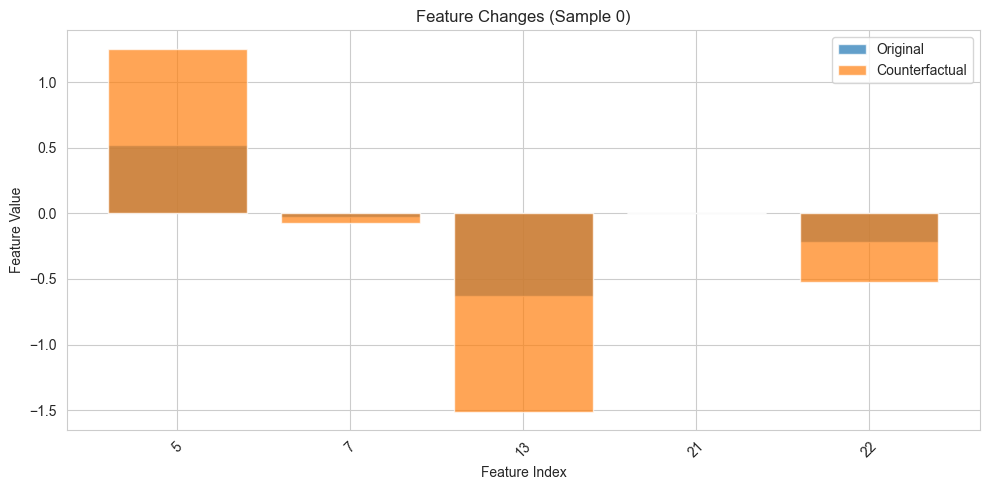

INFO: 
Sample 1:

INFO: Original Output: 13.5800

INFO: Counterfactual Output: 12.8208

INFO: Absolute Change: 0.7592

INFO: Feature Changes in Important Features: [80.00000155067116, 79.99999118642896, 79.99999177546133, 
80.00000182203276, 79.99999480710201]

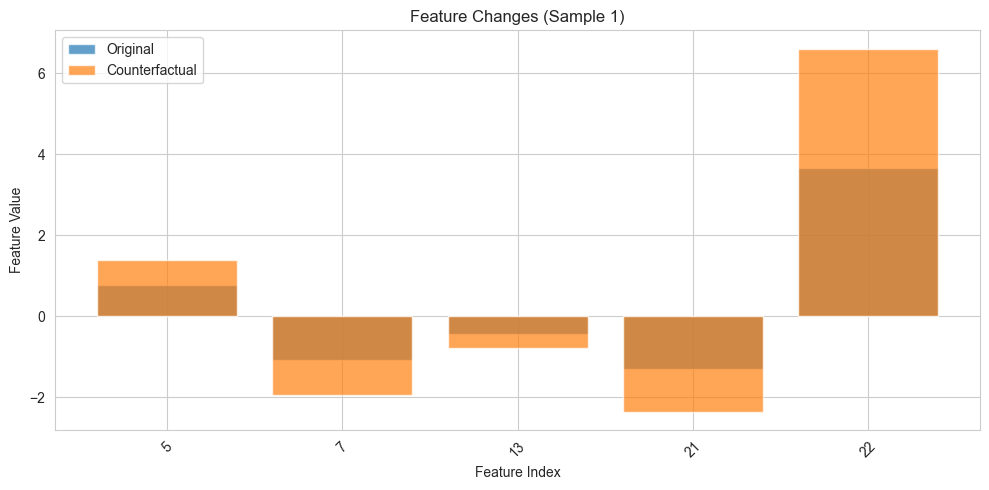

INFO: 
Sample 2:

INFO: Original Output: 10.8000

INFO: Counterfactual Output: 11.2185

INFO: Absolute Change: 0.4185

INFO: Feature Changes in Important Features: [179.9999941489014, 179.99998336389524, 179.9999912558568, 
179.99999744229055, 180.00000814649516]

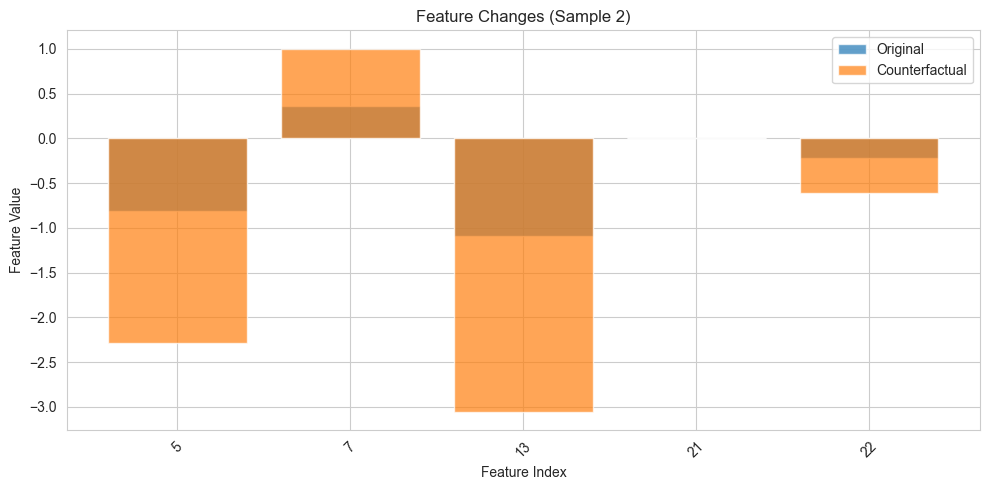

INFO: 
Sample 3:

INFO: Original Output: 16.9600

INFO: Counterfactual Output: 13.9175

INFO: Absolute Change: 3.0425

INFO: Feature Changes in Important Features: [100.0, 100.0, 100.0, 100.0, 100.0]

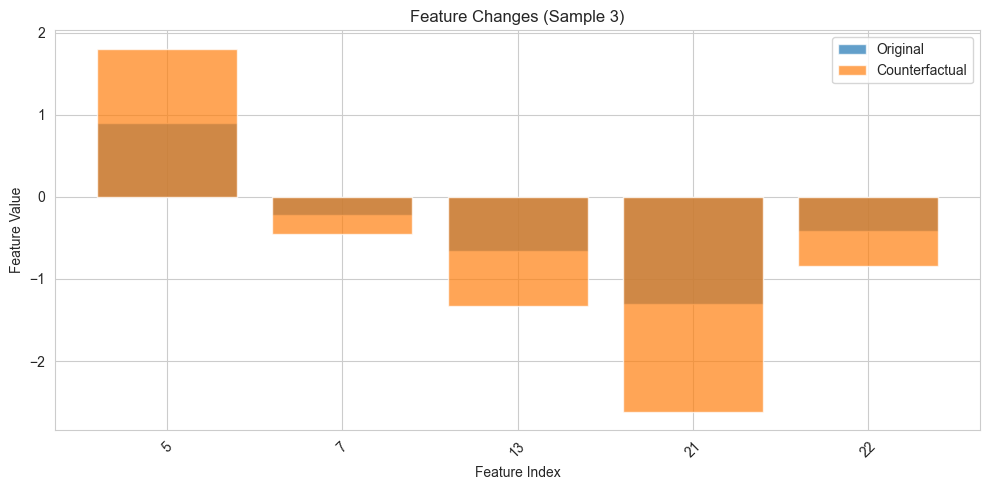

INFO: 
Sample 6:

INFO: Original Output: 10.0000

INFO: Counterfactual Output: 10.7934

INFO: Absolute Change: 0.7934

INFO: Feature Changes in Important Features: [100.0, 100.0, 100.0, 100.0, 100.0]

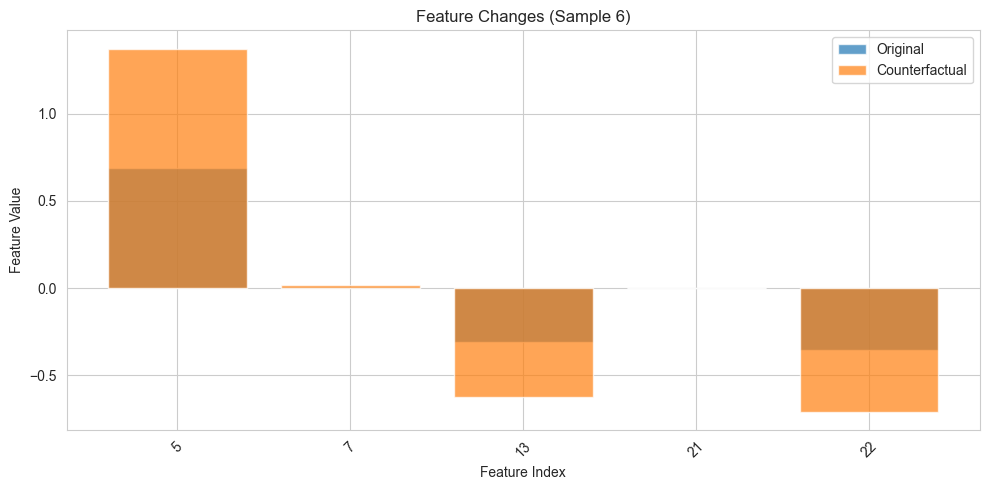

INFO: 
Sample 7:

INFO: Original Output: 13.5000

INFO: Counterfactual Output: 12.7219

INFO: Absolute Change: 0.7781

INFO: Feature Changes in Important Features: [39.99999769827836, 40.00000370495904, 39.99999398289879, 
39.999996355934464, 39.99999300191083]

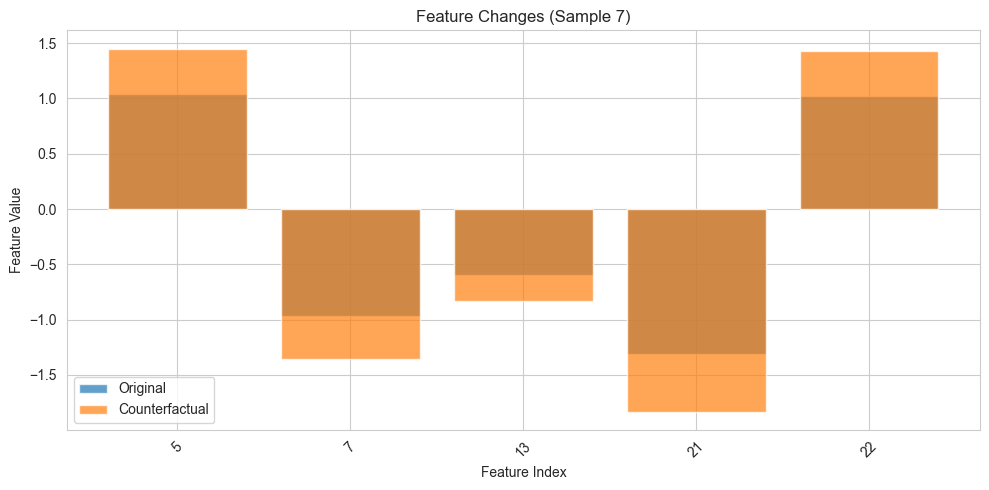

INFO: 
Sample 9:

INFO: Original Output: 9.1300

INFO: Counterfactual Output: 8.6687

INFO: Absolute Change: 0.4613

INFO: Feature Changes in Important Features: [60.00000682176402, 60.000004696160744, 59.99999659182571, 
60.000003693624556, 60.00000271549839]

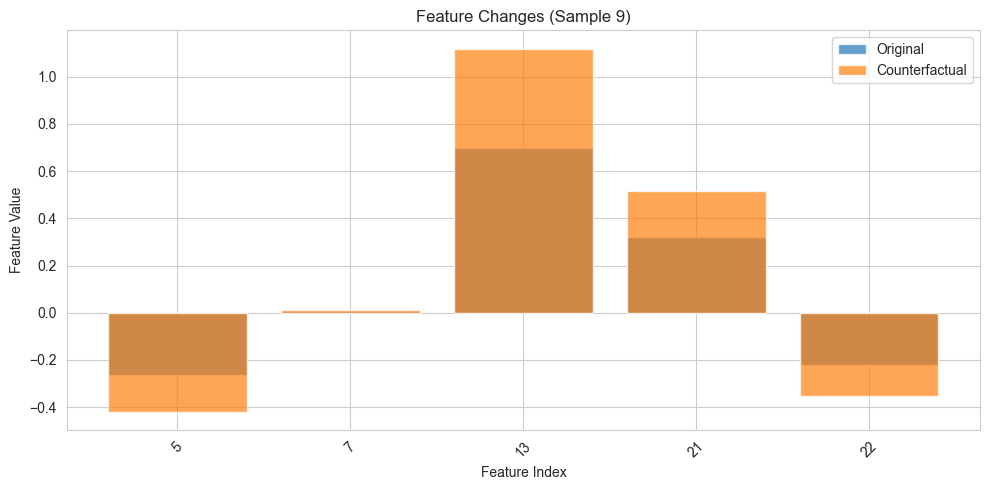

INFO: 
Sample 10:

INFO: Original Output: 9.7500

INFO: Counterfactual Output: 11.3635

INFO: Absolute Change: 1.6135

INFO: Feature Changes in Important Features: [80.00000197179912, 79.99998588327301, 79.99999852289828, 
79.99999104801697, 79.99999494478739]

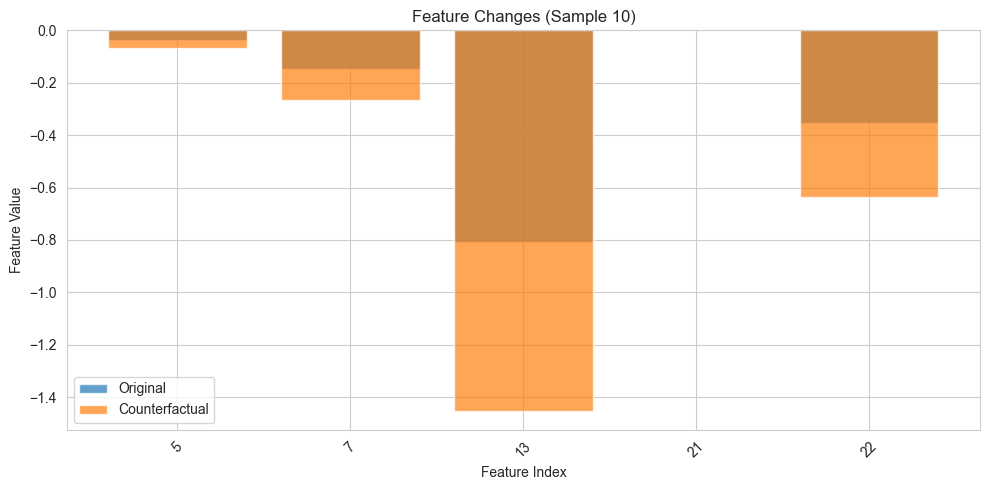

INFO: 
Sample 11:

INFO: Original Output: 16.3800

INFO: Counterfactual Output: 19.2171

INFO: Absolute Change: 2.8371

INFO: Feature Changes in Important Features: [59.9999964136847, 59.99999740399975, 59.99999757052965, 
60.000003644065536, 60.00000271549839]

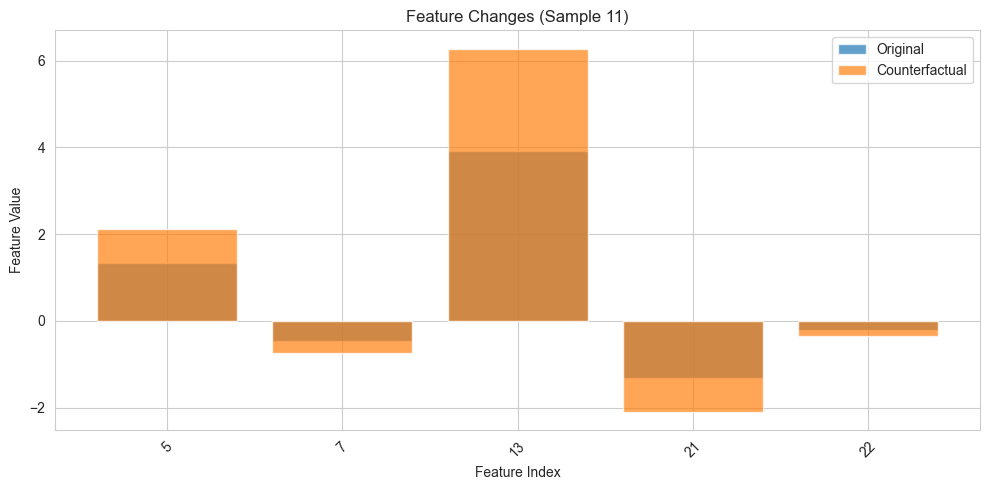

INFO: 
Sample 13:

INFO: Original Output: 16.2100

INFO: Counterfactual Output: 15.6880

INFO: Absolute Change: 0.5220

INFO: Feature Changes in Important Features: [20.0, 20.000001823207405, 20.000001814547115, 20.00000728813107, 
20.00000505521261]

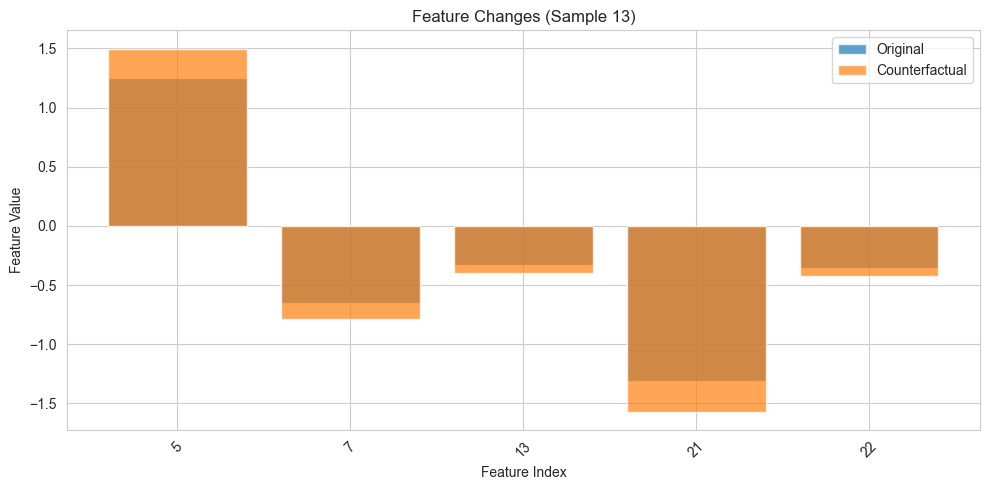

INFO: 
Sample 16:

INFO: Original Output: 10.0000

INFO: Counterfactual Output: 9.7957

INFO: Absolute Change: 0.2043

INFO: Feature Changes in Important Features: [249.99999572034434, 249.9999967827881, 250.0000069382646, 250.0, 
249.99999440807392]

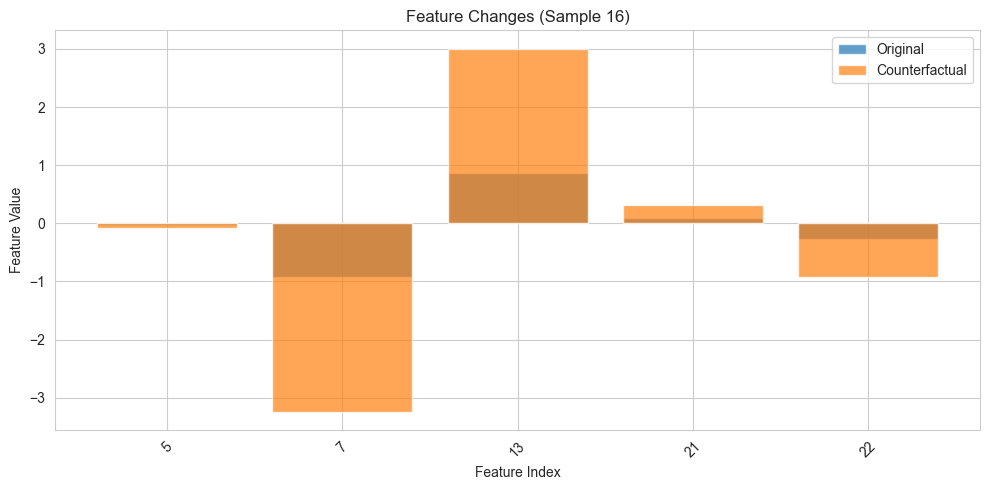

INFO: 
Sample 17:

INFO: Original Output: 11.0000

INFO: Counterfactual Output: 11.4059

INFO: Absolute Change: 0.4059

INFO: Feature Changes in Important Features: [70.0000080524137, 70.00000939232149, 70.00001086254589, 
69.99999936057264, 70.00000926788978]

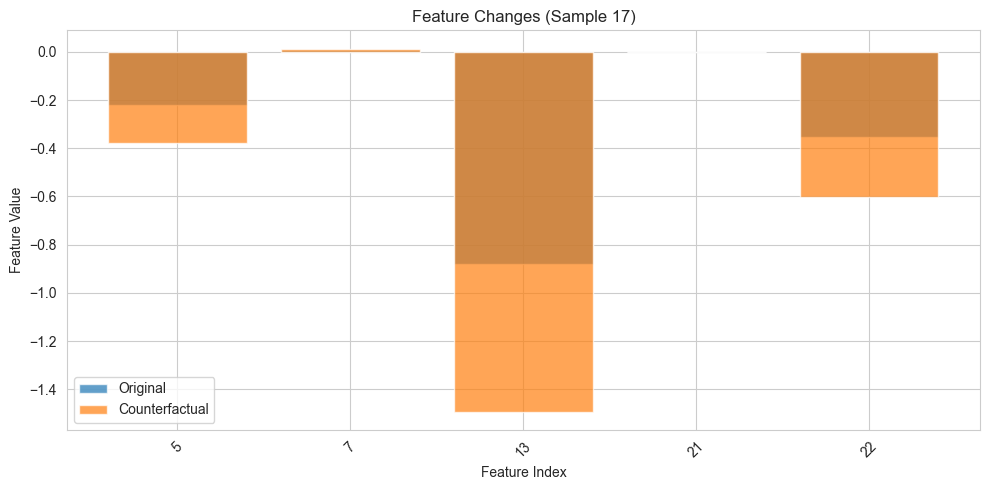

INFO: 
Sample 18:

INFO: Original Output: 11.6300

INFO: Counterfactual Output: 11.4959

INFO: Absolute Change: 0.1341

INFO: Feature Changes in Important Features: [140.0, 140.00001685961678, 140.00000812348264, 140.00001328915133, 
140.00001978491082]

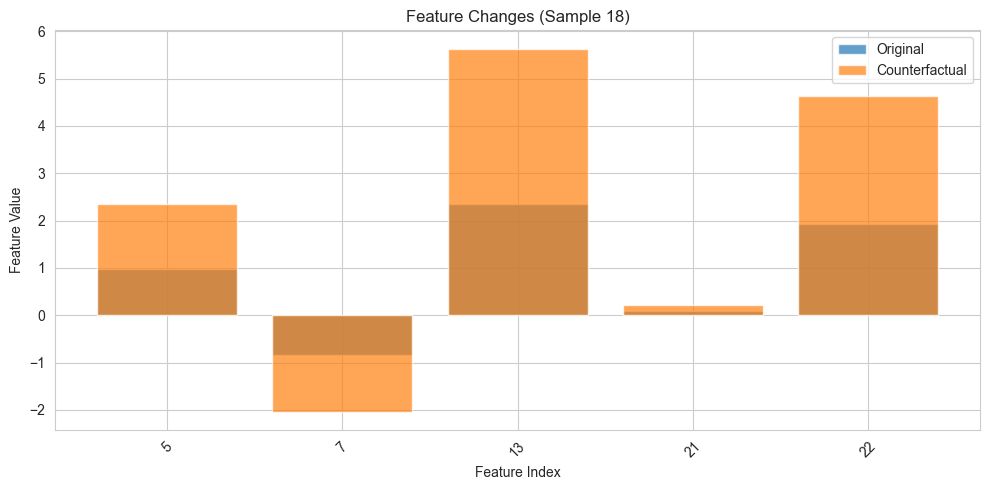

INFO: 
Sample 19:

INFO: Original Output: 15.3800

INFO: Counterfactual Output: 14.9346

INFO: Absolute Change: 0.4454

INFO: Feature Changes in Important Features: [20.000003753291285, 20.000006187644495, 20.000003947132893, 
20.00000728813107, 20.0]

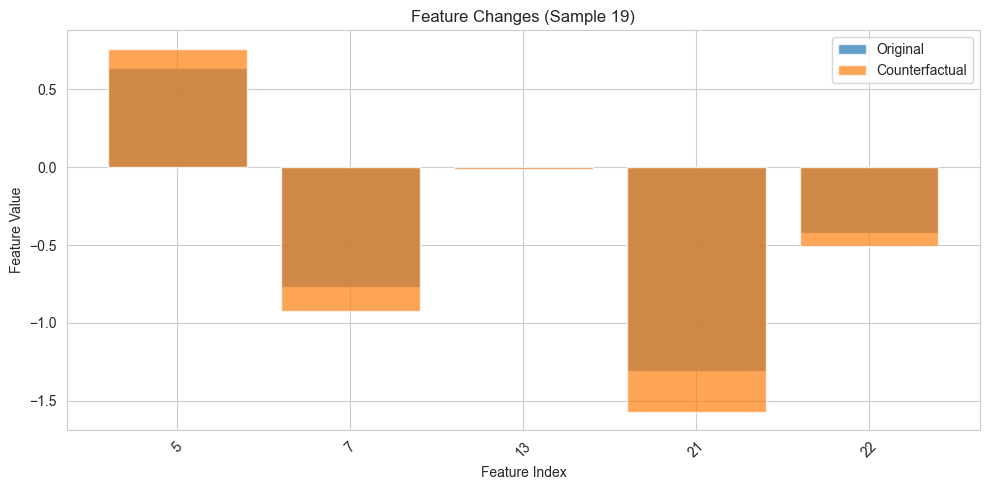

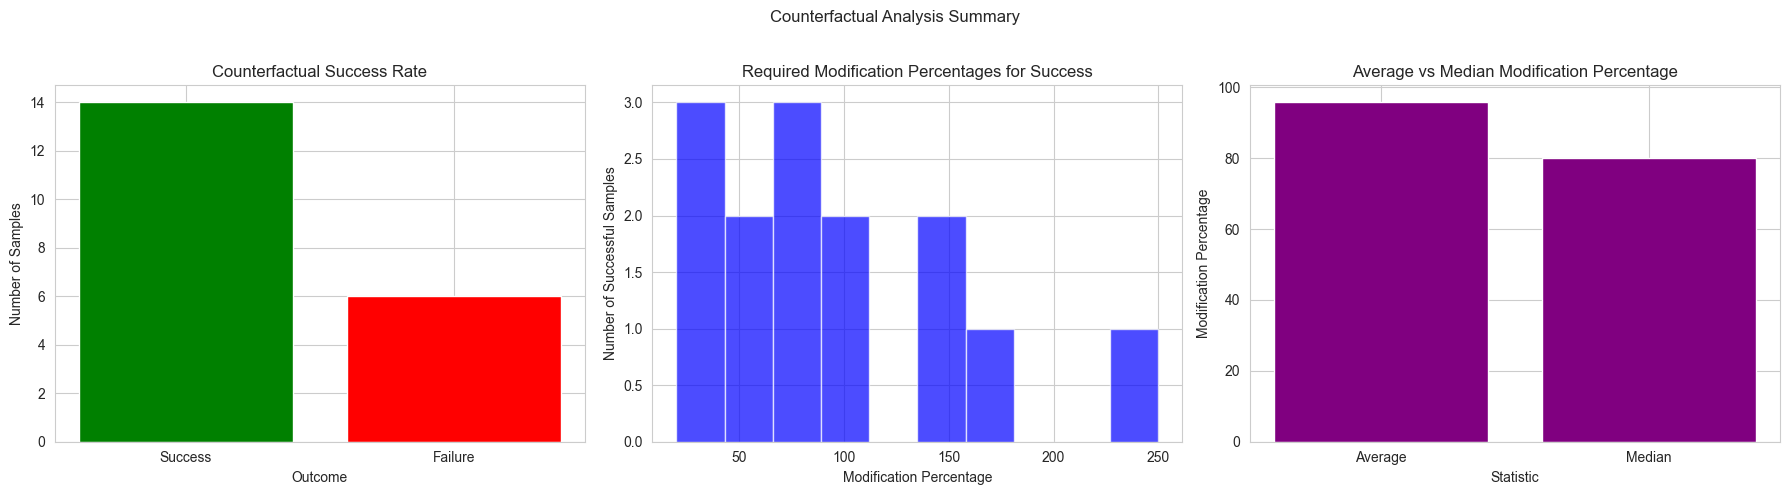

INFO: Total Successful Counterfactuals: 14/20

INFO: Average Modification Percentage for Success: 95.71%

INFO: Median Modification Percentage for Success: 80.00%

In [37]:
# Output analysis summary and plot results for each sample
for result in analysis_results:
    logger.info(f"\nSample {result['sample_index']}:")
    logger.info(f"Original Output: {result['original_output']:.4f}")
    logger.info(f"Counterfactual Output: {result['counterfactual_output']:.4f}")
    logger.info(f"Absolute Change: {abs(result['counterfactual_output'] - result['original_output']):.4f}")
    logger.info(f"Feature Changes in Important Features: {result['feature_changes']}")

    important_features = np.where(input_feature_importance > 0.75)[0]
    original_values = result['original_data'][important_features]
    counterfactual_values = result['counterfactual_data'][important_features]

    # Plot original vs counterfactual feature values for important features
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(range(len(important_features)), original_values, label="Original", alpha=0.7)
    ax.bar(range(len(important_features)), counterfactual_values, label="Counterfactual", alpha=0.7)
    ax.set_xticks(range(len(important_features)))
    ax.set_xticklabels(important_features, rotation=45)
    ax.set_title(f"Feature Changes (Sample {result['sample_index']})")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Feature Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Collect results for overall analysis
success_count = sum(1 for result in analysis_results if result is not None)
failure_count = len(data_samples) - success_count

# For successful samples, retrieve the minimum modification percentage required
modification_percentages = [np.mean(result["feature_changes"]) for result in analysis_results if result is not None]

# Plot 1: Counterfactual Success Rate Across Samples
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot success rate
ax[0].bar(["Success", "Failure"], [success_count, failure_count], color=["green", "red"])
ax[0].set_title("Counterfactual Success Rate")
ax[0].set_ylabel("Number of Samples")
ax[0].set_xlabel("Outcome")

# Plot modification percentage distribution for successful samples
ax[1].hist(modification_percentages, bins=10, color="blue", alpha=0.7)
ax[1].set_title("Required Modification Percentages for Success")
ax[1].set_xlabel("Modification Percentage")
ax[1].set_ylabel("Number of Successful Samples")

# Plot average required modification percentage
if modification_percentages:
    avg_modification = np.mean(modification_percentages)
    median_modification = np.median(modification_percentages)
    ax[2].bar(["Average", "Median"], [avg_modification, median_modification], color="purple")
    ax[2].set_title("Average vs Median Modification Percentage")
    ax[2].set_ylabel("Modification Percentage")
    ax[2].set_xlabel("Statistic")

# Display plots
plt.suptitle("Counterfactual Analysis Summary")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Log final statistics
logger.info(f"Total Successful Counterfactuals: {success_count}/{len(data_samples)}")
if modification_percentages:
    logger.info(f"Average Modification Percentage for Success: {avg_modification:.2f}%")
    logger.info(f"Median Modification Percentage for Success: {median_modification:.2f}%")